In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from webbpsf import NIRCam
from astropy.io import fits
from jwst.resample import resample_step
from jwst.datamodels import ImageModel
import os, copy
os.environ['WEBBPSF_PATH'] = '/quasar/yichenliu/webbpsf-data'

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from webbpsf import NIRCam
from jwst.datamodels import ImageModel
from astropy.wcs import WCS

# Initialize NIRCam with F250M filter
nircam = NIRCam()
nircam.filter = 'F250M'

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'none'

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import os, sys

from importlib import reload

import numpy as np
import numpy.linalg as la
from numpy import fft

import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import AsinhStretch
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import astropy_mpl_style
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData
from astropy.modeling import models
from astropy import coordinates as coord
from astropy import units as u

from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars
from photutils.centroids import centroid_com

from scipy.ndimage import shift, zoom

from reproject import reproject_interp

from jwst.resample.resample import ResampleData
from jwst.resample import ResampleStep
from jwst.datamodels import ModelContainer, ModelLibrary

import gwcs
from gwcs import coordinate_frames as cf

stretch = AsinhStretch()

plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

sys.path.append('..')

import dither.utils as dutils
import dither.wrapper as wrapper
import dither.updated as updated

### prepare simulated data

make oversampled image

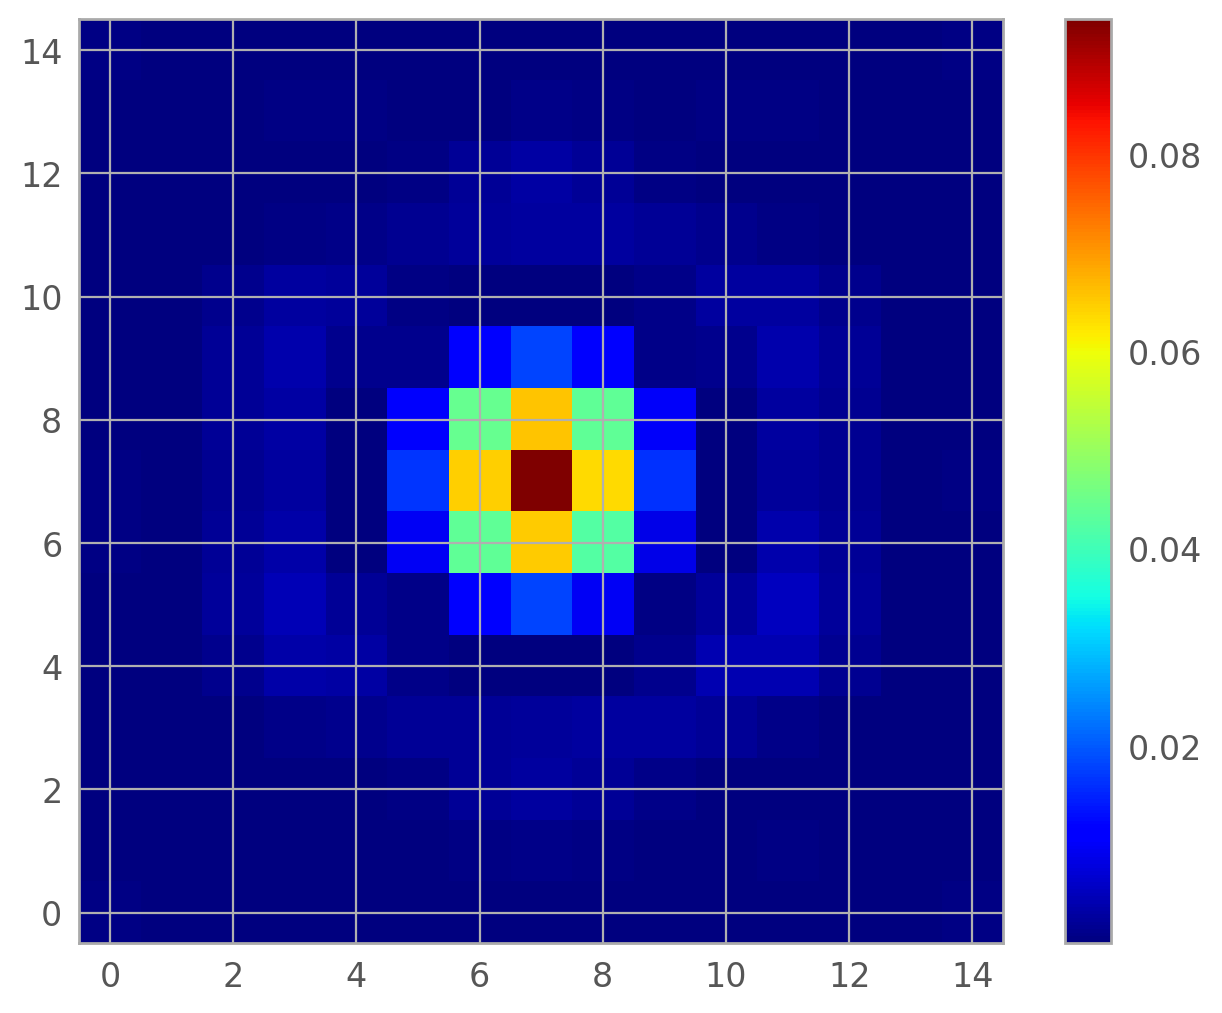

In [2]:
# Generate oversampled PSF (factor of 2)
oversample_factor = 2
app = 0.063 # pixel scale in arcsec / pixel for SW channel
nircam.options['source_offset_x'] = 0.25*app
nircam.options['source_offset_y'] = 0.25*app
oversampled_psf = nircam.calc_psf(oversample=oversample_factor)
oversampled_data = oversampled_psf[0].data[1:158, 1:158]

plt.imshow(dutils.extract_central_region(oversampled_data), cmap='jet')
plt.colorbar()

make 9 dither images

In [ ]:
num_dithers = 9
dither_images = []
# random dither pattern
dither_offsets_pixel = np.random.rand(num_dithers, 2) - 0.5  # pixel
# enlarge the offset FOR TESTING PURPOSE
dither_offsets_pixel *= 50
# some method is aligned with the first image
dither_offsets_pixel[0] = [0, 0]
# offsets in arcsec
dither_offsets = dither_offsets_pixel*app # arcsec

for i, (dx, dy) in enumerate(dither_offsets):
    print(f'dither position {i}, dx={dx:5.4f} arcsec, dy={dy:5.4f} arcsec')
    # set the image shift for dithering
    nircam.options['source_offset_x'] = dx
    nircam.options['source_offset_y'] = dy
    psfdu = nircam.calc_psf(oversample=1)
    # save data. we only need the array and do not need header
    psf = psfdu[0].data
    # add noise
    # psf += np.random.normal(loc=0, scale=0.39/5, size=psf.shape) # roughly 5 sigma noise
    dither_images.append(psf)

dither position 0, dx=0.0000 arcsec, dy=0.0000 arcsec
dither position 1, dx=-0.9658 arcsec, dy=0.4355 arcsec
dither position 2, dx=-0.0844 arcsec, dy=-0.4592 arcsec
dither position 3, dx=0.5299 arcsec, dy=0.1154 arcsec
dither position 4, dx=0.5988 arcsec, dy=1.1534 arcsec
dither position 5, dx=0.0576 arcsec, dy=-0.1444 arcsec
dither position 6, dx=-1.0027 arcsec, dy=-0.4784 arcsec
dither position 7, dx=0.0618 arcsec, dy=1.3798 arcsec
dither position 8, dx=1.4206 arcsec, dy=1.1166 arcsec


position uncertainty

In [ ]:
# # add 20% position noise

# dither_offsets_pixel_bak = dither_offsets_pixel.copy()
# dither_offsets_bak = dither_offsets.copy()

# dither_offsets_pixel += np.random.rand(9, 2)*0.4-0.2
# dither_offsets = dither_offsets_pixel*app

In [ ]:
# # restore changes
# dither_offsets_pixel = dither_offsets_pixel_bak
# dither_offsets = dither_offsets_bak

noise

In [86]:
# add 20% noise

dither_images_bak = copy.deepcopy(dither_images)

for psf in dither_images:
    psf += np.random.normal(loc=0, scale=0.39/5, size=psf.shape) # roughly 5 sigma noise

In [ ]:
# restore change

dither_images = dither_images_bak

save them in JWST pipeline readable form

In [87]:
outdir = 'dither_images'

for i in range(9):
    outpath = os.path.join(outdir, 'WebbPSF', f'{i}_F250M_sci.fits')
    print(outpath)
    nx, ny = dither_images[i].shape
    ra_shift, dec_shift = -dither_offsets[i]/3600 # in degree
    model = ImageModel(data=dither_images[i])
    # ImageModel wcs parameters
    model.meta.wcsinfo = {
        'dec_ref': 0., # used in calculating scale of pc
        'ra_ref': 0., # used in calculating scale of pc
        'v3yangle': 0., # used in calculating rotation of pc
        'vparity': 1, # 1 or -1, used in calculating rotation of pc
    }
    # ImageModel exposure parameters
    exposure_attributes = [
        'exposure_time',
        'duration',
        'start_time',
        'end_time',
        'measurement_time',
        'effective_exposure_time',
        'elapsed_exposure_time'
    ]
    for attr in exposure_attributes:
        setattr(model.meta.exposure, attr, 0)
    # ImageModel gwcs construction
    detector_frame = cf.Frame2D(
        name="detector", axes_names=("x", "y"), unit=(u.pix, u.pix), 
        axes_order=(0, 1)
    )
    sky_frame = cf.CelestialFrame(
        reference_frame=coord.ICRS(), name='icrs', unit=(u.deg, u.deg), 
        axes_names=('lon', 'lat'), axes_order=(0, 1)
    )
    pixel_center = models.Shift(offset=-(nx-1)/2, name='crpix1') & \
                   models.Shift(offset=-(ny-1)/2, name='crpix2')
    pc_rotation_matrix = models.AffineTransformation2D(
        matrix=[[1., 0.], [ 0., 1.]], translation=[0., 0.], 
        name='pc_rotation_matrix'
    )
    pixel_scale = models.Scale(factor=app/3600., name='cdelt1') & \
                  models.Scale(factor=app/3600., name='cdelt2') # deg/pixel
    tangent_projection = models.Pix2Sky_Gnomonic()
    celestial_rotation = models.RotateNative2Celestial(
        lon=0., lat=0., lon_pole=180.
    )
    source_offset = models.Shift(offset=ra_shift, name='source_shift_ra') & \
                    models.Shift(offset=dec_shift, name='source_shift_dec')
    forward_transorm = pixel_center | pc_rotation_matrix | pixel_scale | \
                       tangent_projection | celestial_rotation | source_offset
    gwcs_wcs = gwcs.wcs.WCS(
        forward_transform=forward_transorm,
        input_frame=detector_frame,
        output_frame=sky_frame
    )
    model.meta.wcs = gwcs_wcs
    model.save(outpath)

dither_images/WebbPSF/0_F250M_sci.fits
dither_images/WebbPSF/1_F250M_sci.fits
dither_images/WebbPSF/2_F250M_sci.fits
dither_images/WebbPSF/3_F250M_sci.fits
dither_images/WebbPSF/4_F250M_sci.fits
dither_images/WebbPSF/5_F250M_sci.fits
dither_images/WebbPSF/6_F250M_sci.fits
dither_images/WebbPSF/7_F250M_sci.fits
dither_images/WebbPSF/8_F250M_sci.fits


Show images

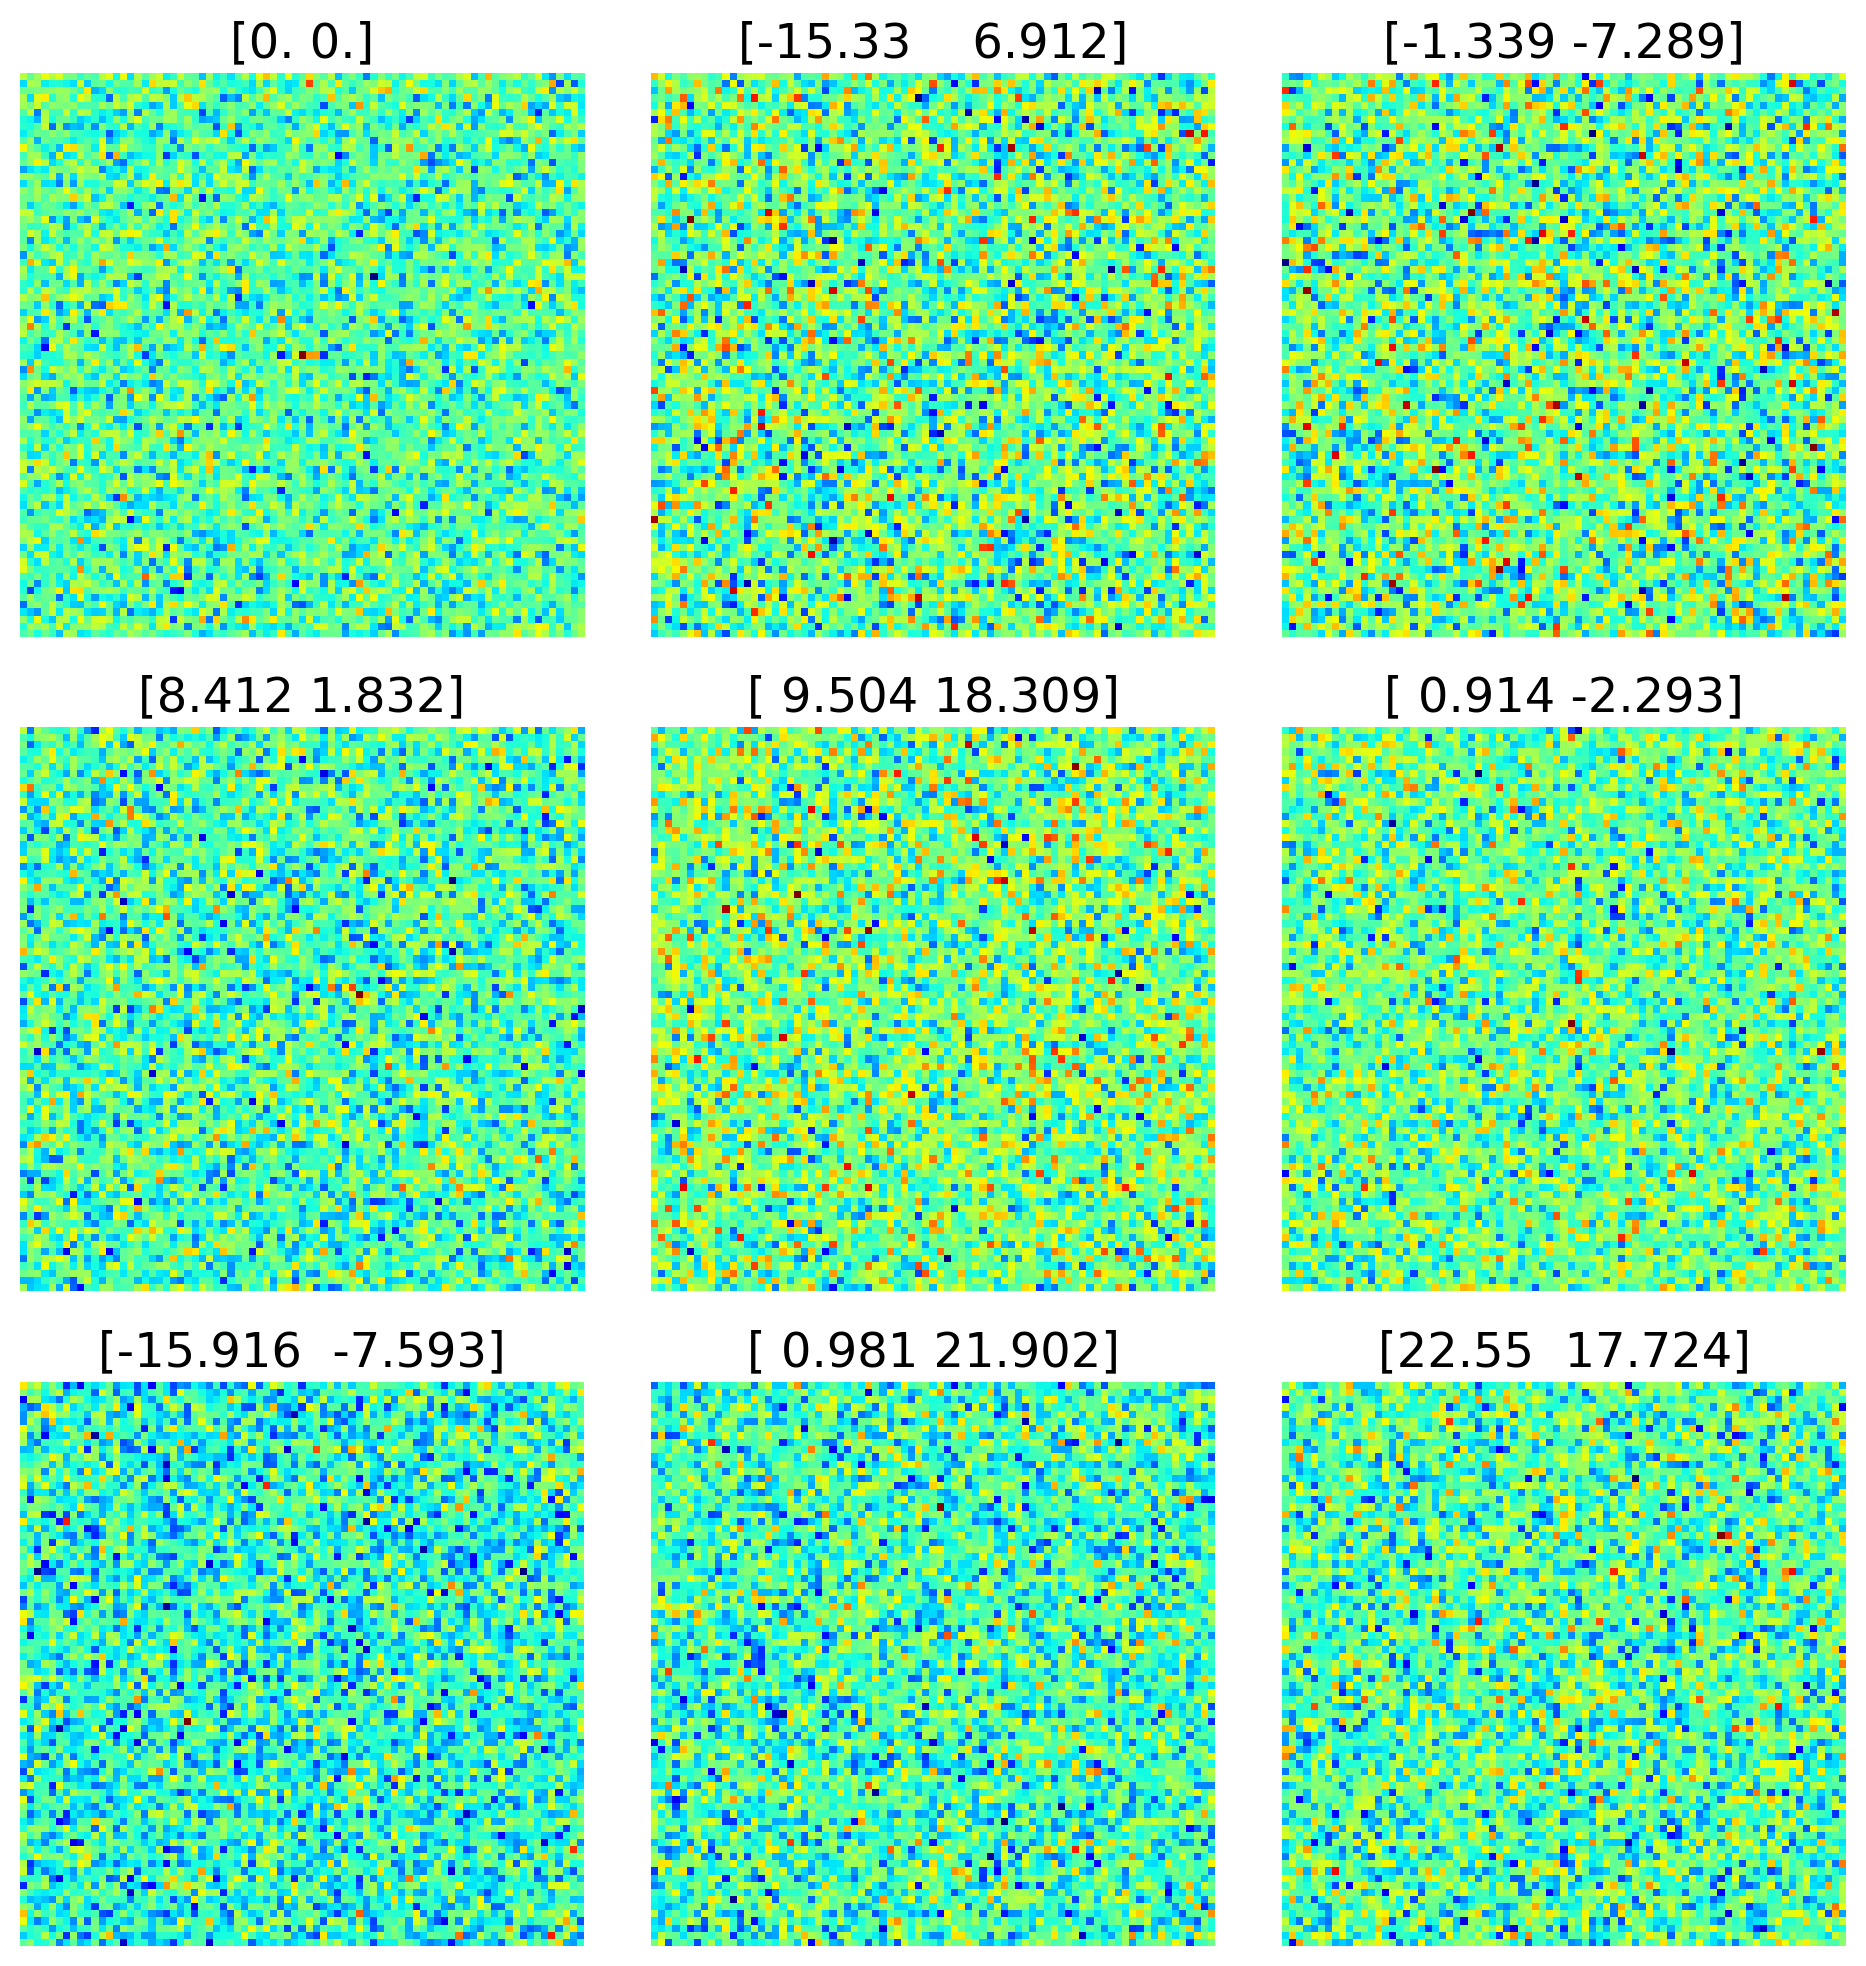

In [88]:
central_dithers = [dutils.extract_central_region(image) for image in dither_images]

# Plot the central part of 9 dithered images in a grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    # ax.imshow(central_dithers[i], origin='lower', cmap='jet')
    ax.imshow(dither_images[i], origin='lower', cmap='jet')
    ax.set_title(dither_offsets_pixel[i])
    ax.axis('off')  # Hide axes for cleaner visualization

plt.tight_layout()
plt.show()

### using Lauer(99) method

In [89]:
aligned_atlas = dither_images
centroids = dither_offsets_pixel
cx = 39
cy = 39

# NOTE: dutils.get_pixel_center_from_array returns 40, need fix?

centroids

array([[  0.   ,   0.   ],
       [-15.33 ,   6.912],
       [ -1.339,  -7.289],
       [  8.412,   1.832],
       [  9.504,  18.309],
       [  0.914,  -2.293],
       [-15.916,  -7.593],
       [  0.981,  21.902],
       [ 22.55 ,  17.724]])

visually check if the input is correct (no messing up x and y etc.)

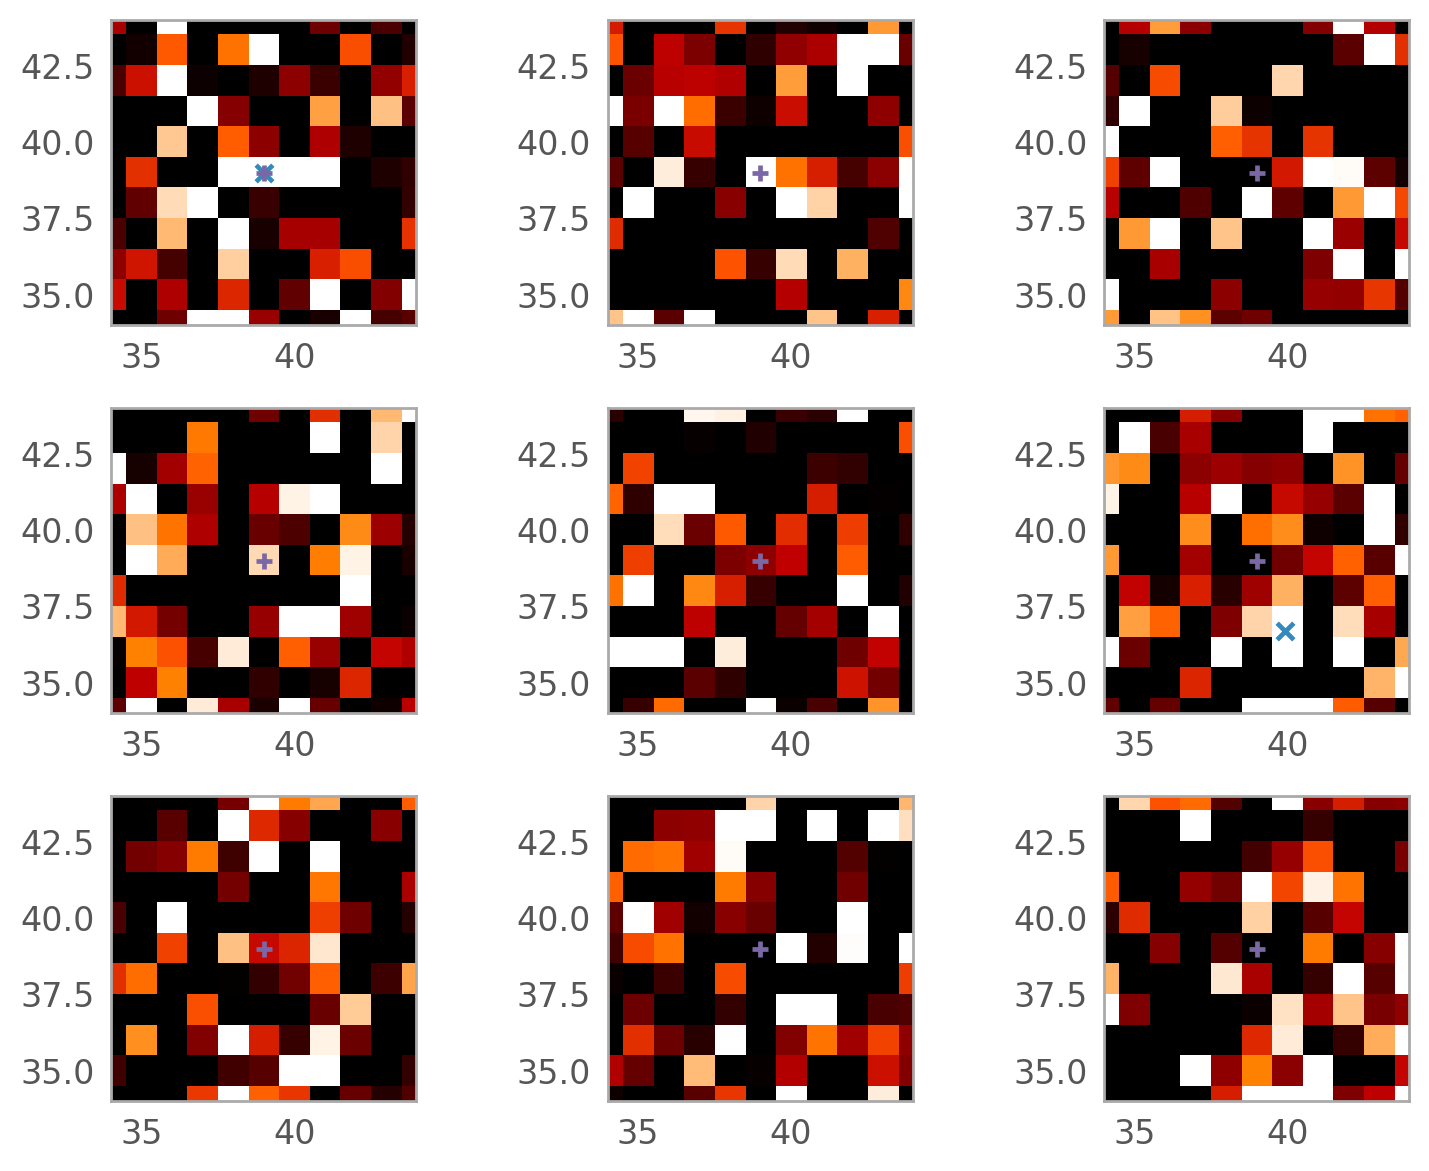

In [90]:
fig, axs = plt.subplots(3, 3)
axs = axs.flat
for i in range(9): 
    data = aligned_atlas[i]
    qso_center = [cx+centroids[i, 0], cx+centroids[i, 1]]
    img_center = [cx, cy]
    axs[i].imshow(np.arcsinh(data), vmin=0, vmax=0.1)
    axs[i].scatter(*qso_center, marker='x')
    axs[i].scatter(*img_center, marker='+')
    axs[i].set_xlim(cx-5, cx+5)
    axs[i].set_ylim(cy-5, cy+5)
    axs[i].grid(False)
plt.tight_layout()
plt.show()

[[  0.      0.      1.   ]
 [  6.912 -15.33    1.   ]
 [ -7.289  -1.339   1.   ]
 [  1.832   8.412   1.   ]
 [ 18.309   9.504   1.   ]
 [ -2.293   0.914   1.   ]
 [ -7.593 -15.916   1.   ]
 [ 21.902   0.981   1.   ]
 [ 17.724  22.55    1.   ]]


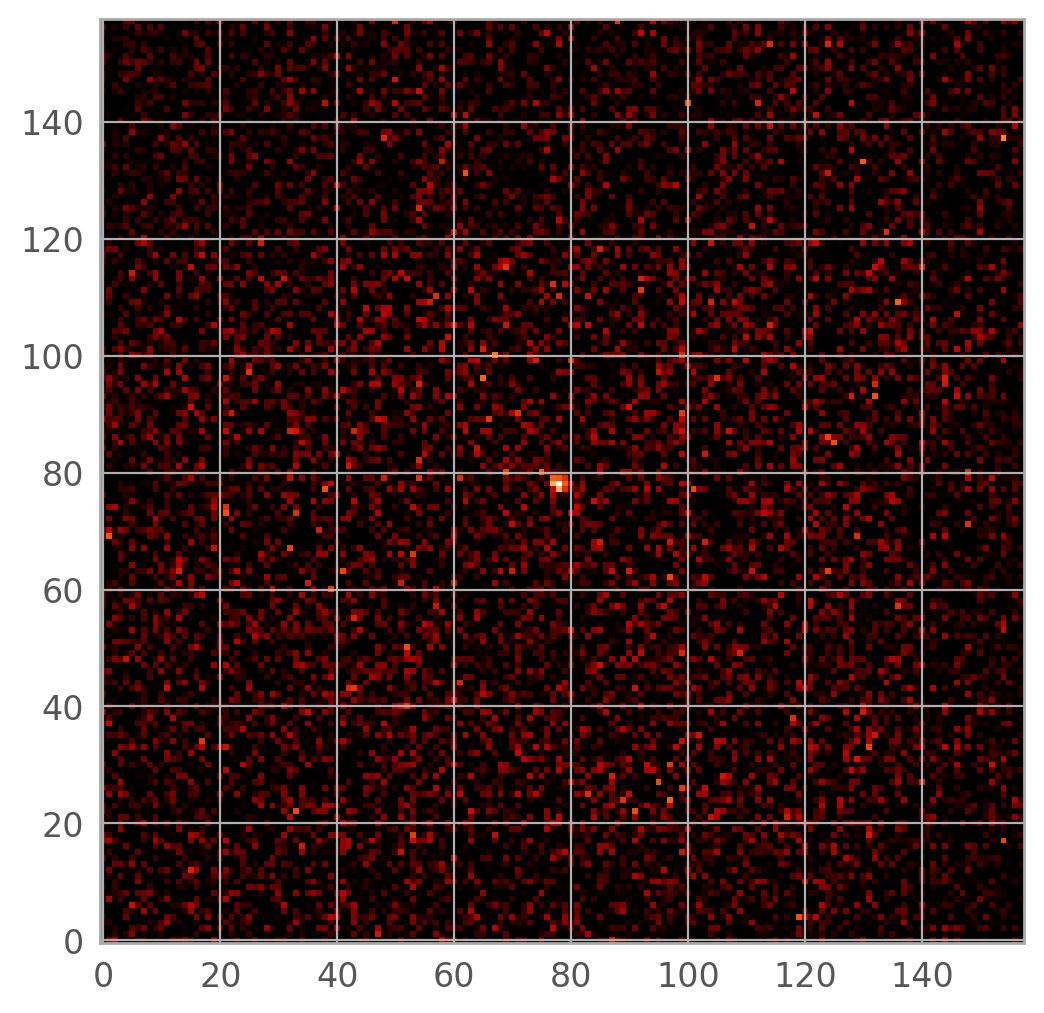

In [91]:
from dither.wrapper import NR_FREQ, NC_FREQ

NSUB = 2

used_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# [y, x, wt]
offsets = np.hstack((centroids[used_indices, 1:2], 
                     centroids[used_indices, 0:1], 
                     [[1]]*len(used_indices)))
# offsets[0, 0] = 0
# offsets[0, 1] = 0
print(offsets)

Atotal = np.zeros((NC_FREQ, NR_FREQ))
for i, j in enumerate(used_indices): 
    data = aligned_atlas[j]
    nx, ny = data.shape
    data_large = np.zeros((NC_FREQ, NR_FREQ))
    data_large[:nx*NSUB:NSUB, :ny*NSUB:NSUB] = data
    A = updated.real2dfft_forward(data_large)
    n = i + 1
    Aphased = updated.phase_shift(A, offsets, n, verbose=False)
    Atotal += Aphased

f = updated.real2dfft_backward(Atotal)

proper_coadded_image = f[0:157, 0:157]/4

# plotting code
nx, ny = aligned_atlas[0].shape
nx_large = nx*NSUB
ny_large = ny*NSUB
plt.imshow(stretch(f[:nx_large, :ny_large]))
plt.show()

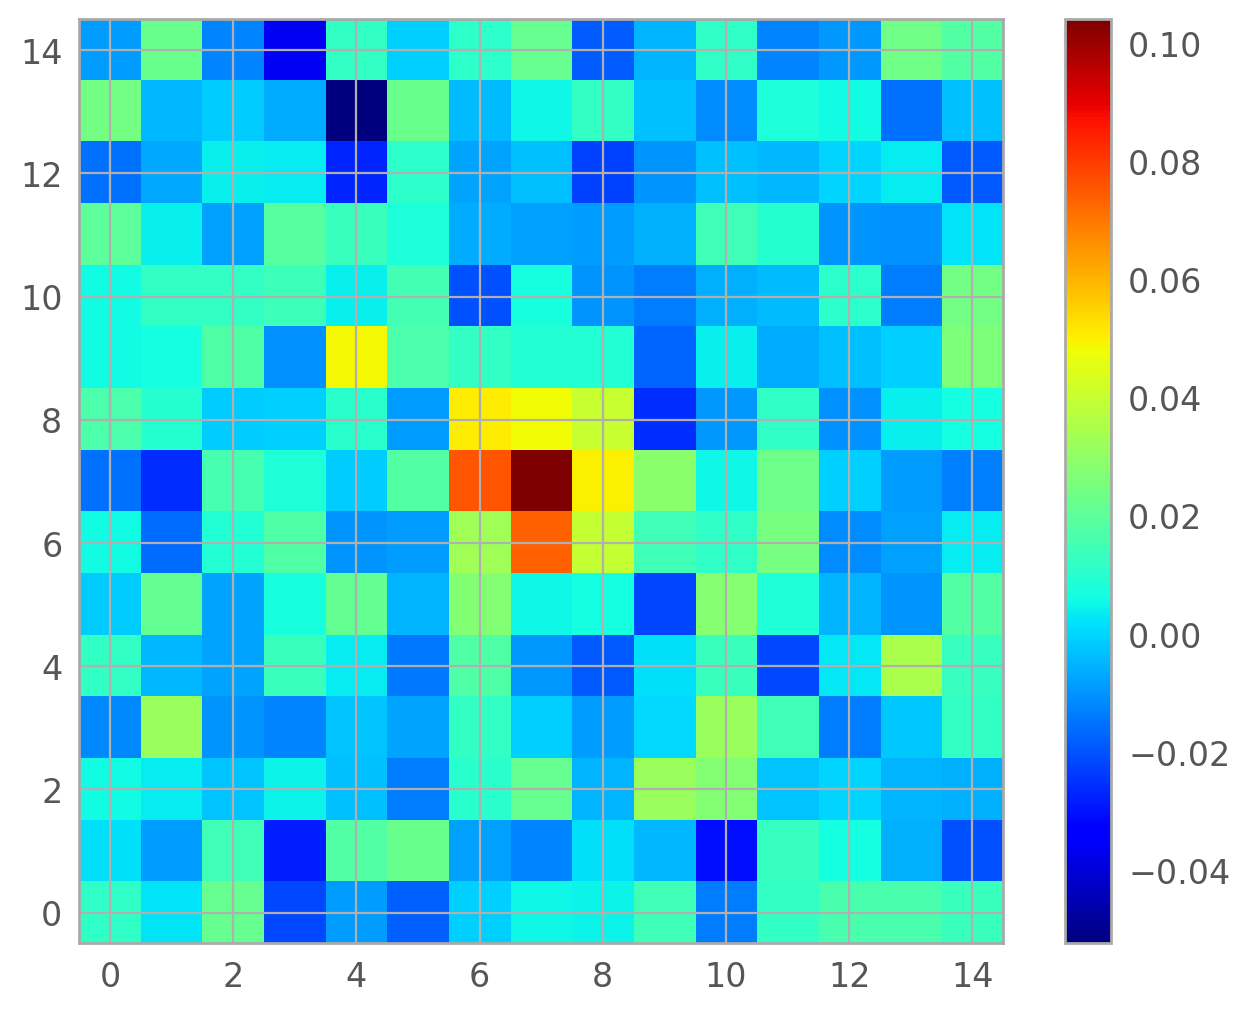

In [92]:
# TODO: change the pixel center for even number dimension arrays, and that could be an additional instruction for the package

plt.imshow(dutils.extract_central_region(proper_coadded_image), cmap='jet')
plt.colorbar()

test residual

0.06196113081402527

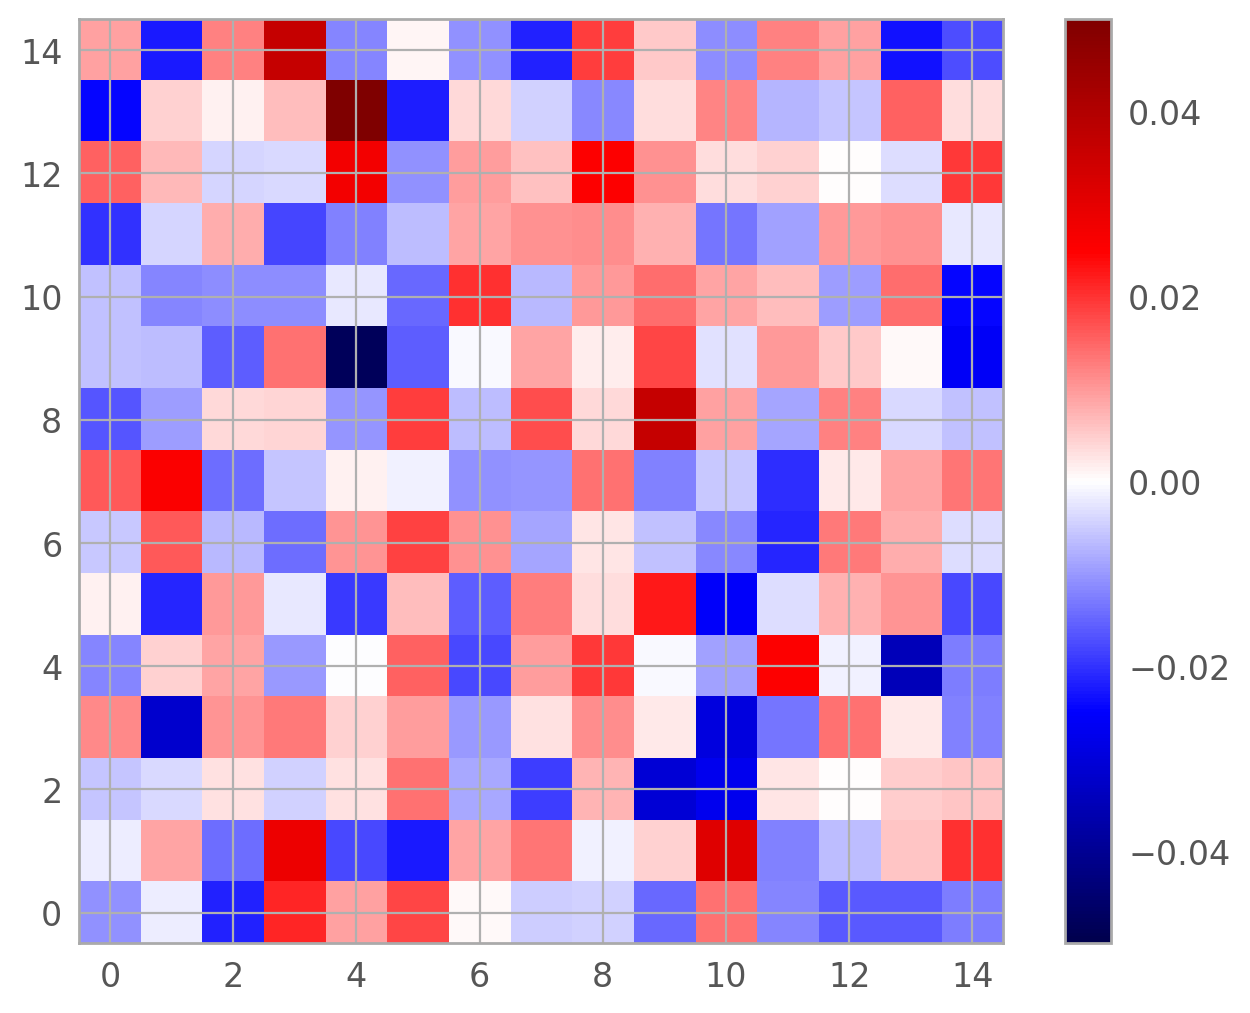

In [93]:
res = oversampled_data - proper_coadded_image
plt.imshow(dutils.extract_central_region(res),
           cmap='seismic', vmin=-0.05, vmax=0.05)
plt.colorbar()

np.max(np.abs(res))

show power spectrum

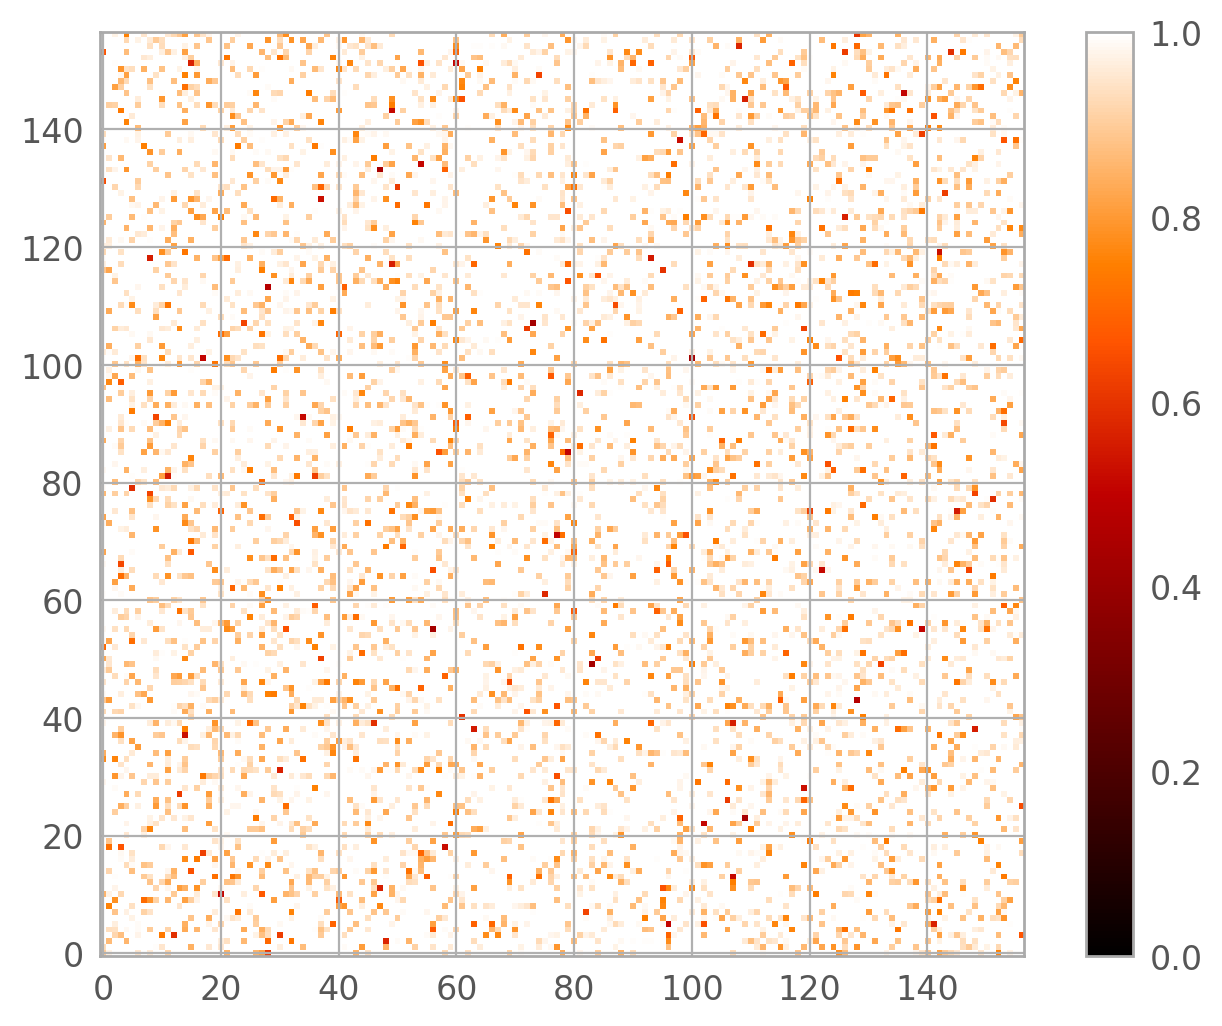

In [94]:
# pow = dutils.get_power_spectrum_from_realfft2d(wrapper.fft(proper_coadd_image))
pow = dutils.get_power_spectrum(fft.fft2(proper_coadded_image))
plt.imshow(pow**0.1, vmin=0, vmax=1)
plt.colorbar()
plt.show()

### Minimalist drizzle regardless of WCS

by only interpolating the x and y in pixel unit

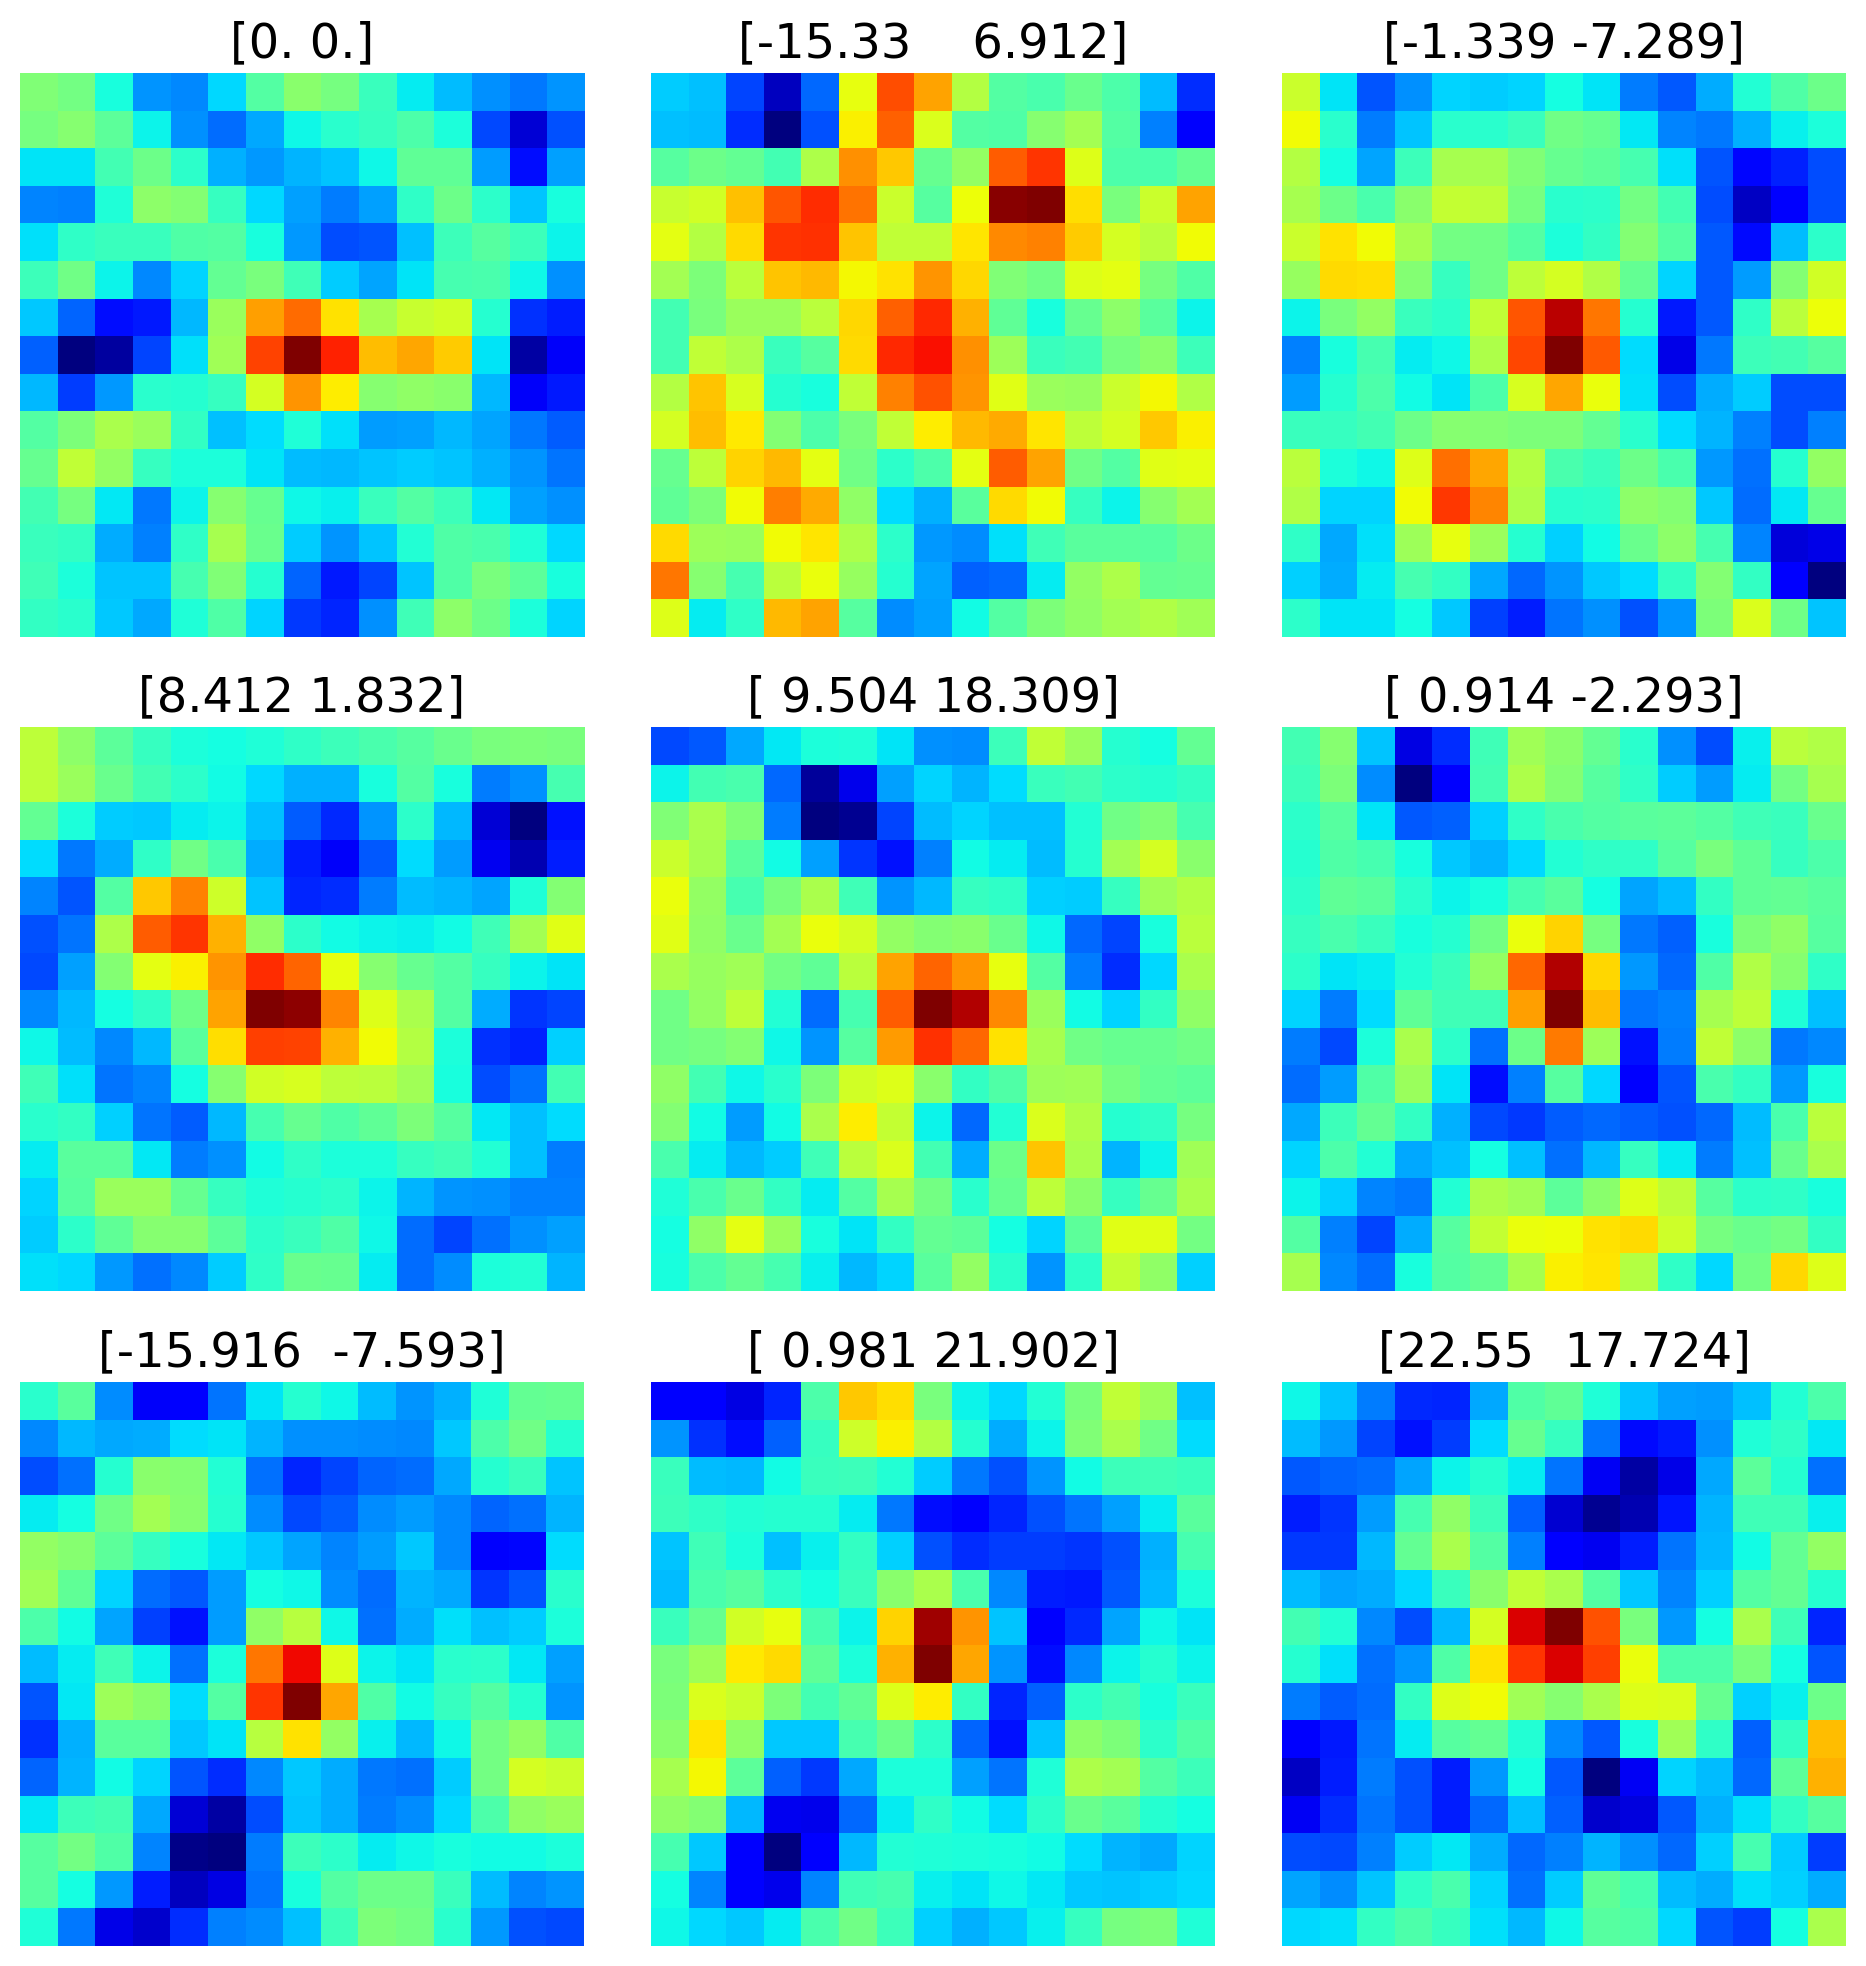

In [95]:
shifted_images = []
for image, (dx, dy) in zip(dither_images, dither_offsets_pixel):
    # shifted_image = enlarge_and_reproject(image, dx, dy)
    shifted_image = image.copy()
    shifted_image = zoom(shifted_image, zoom=2)/4
    shifted_image = shift(shifted_image, shift=[-dy*2+0.5, -dx*2+0.5], order=3)
    shifted_images.append(shifted_image)

minimal_drizzled_image = np.sum(shifted_images, axis=0)[1:158, 1:158]/9

# Plot the central part of 9 dithered images in a grid

central_dithers = [dutils.extract_central_region(image) for image in shifted_images]

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.imshow(central_dithers[i], origin='lower', cmap='jet')
    ax.set_title(dither_offsets_pixel[i])
    ax.axis('off')  # Hide axes for cleaner visualization

plt.tight_layout()
plt.show()

show result

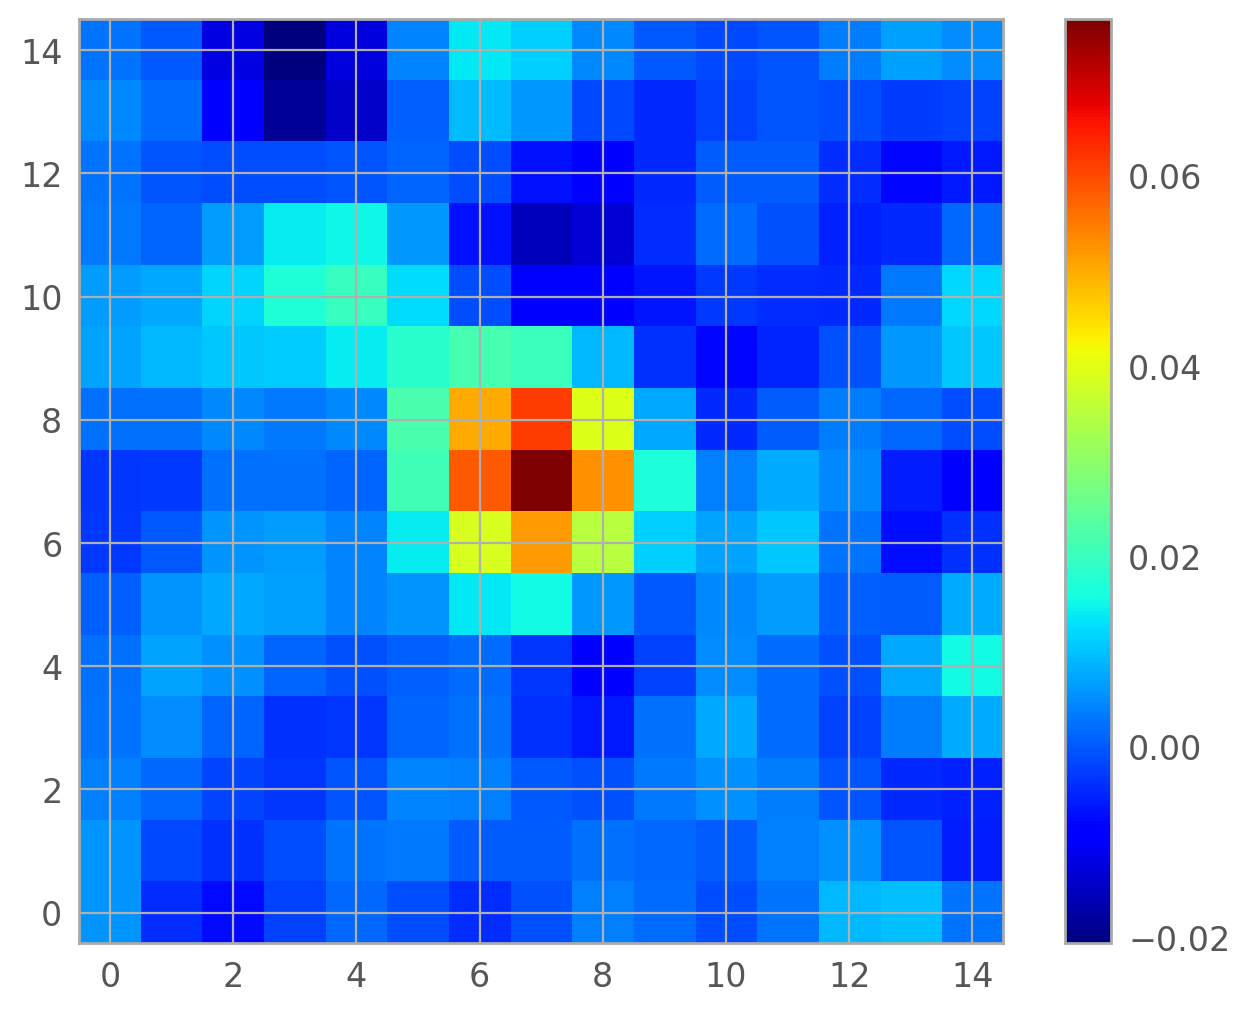

In [96]:
plt.imshow(dutils.extract_central_region(minimal_drizzled_image), cmap='jet')
plt.colorbar()

test residual

0.0227243859810715

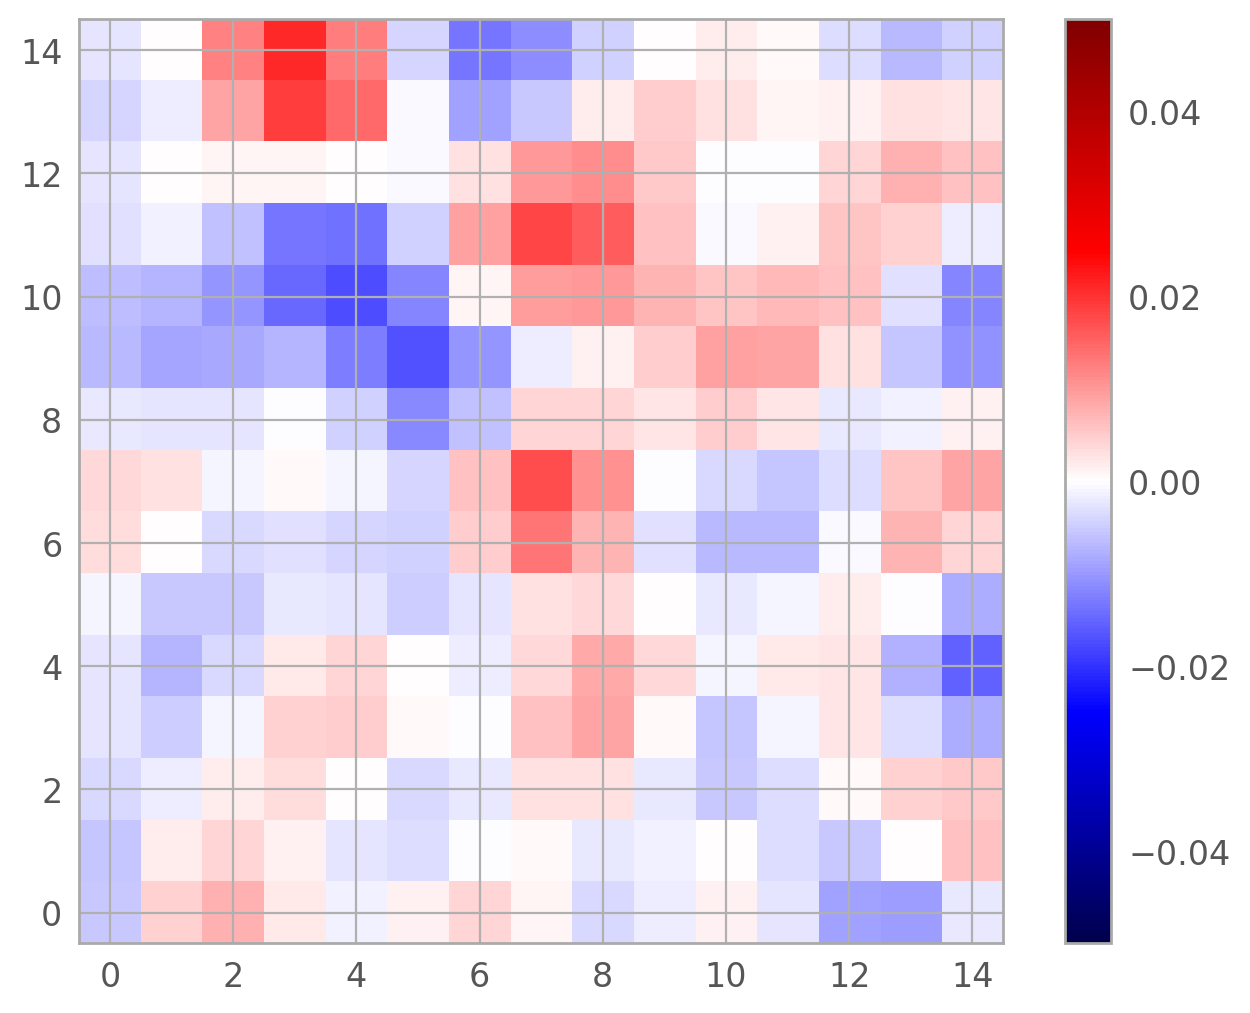

In [97]:
res = oversampled_data - minimal_drizzled_image
plt.imshow(dutils.extract_central_region(res),
           cmap='seismic', vmin=-0.05, vmax=0.05)
plt.colorbar()

np.max(np.abs(res))

show power spectrum

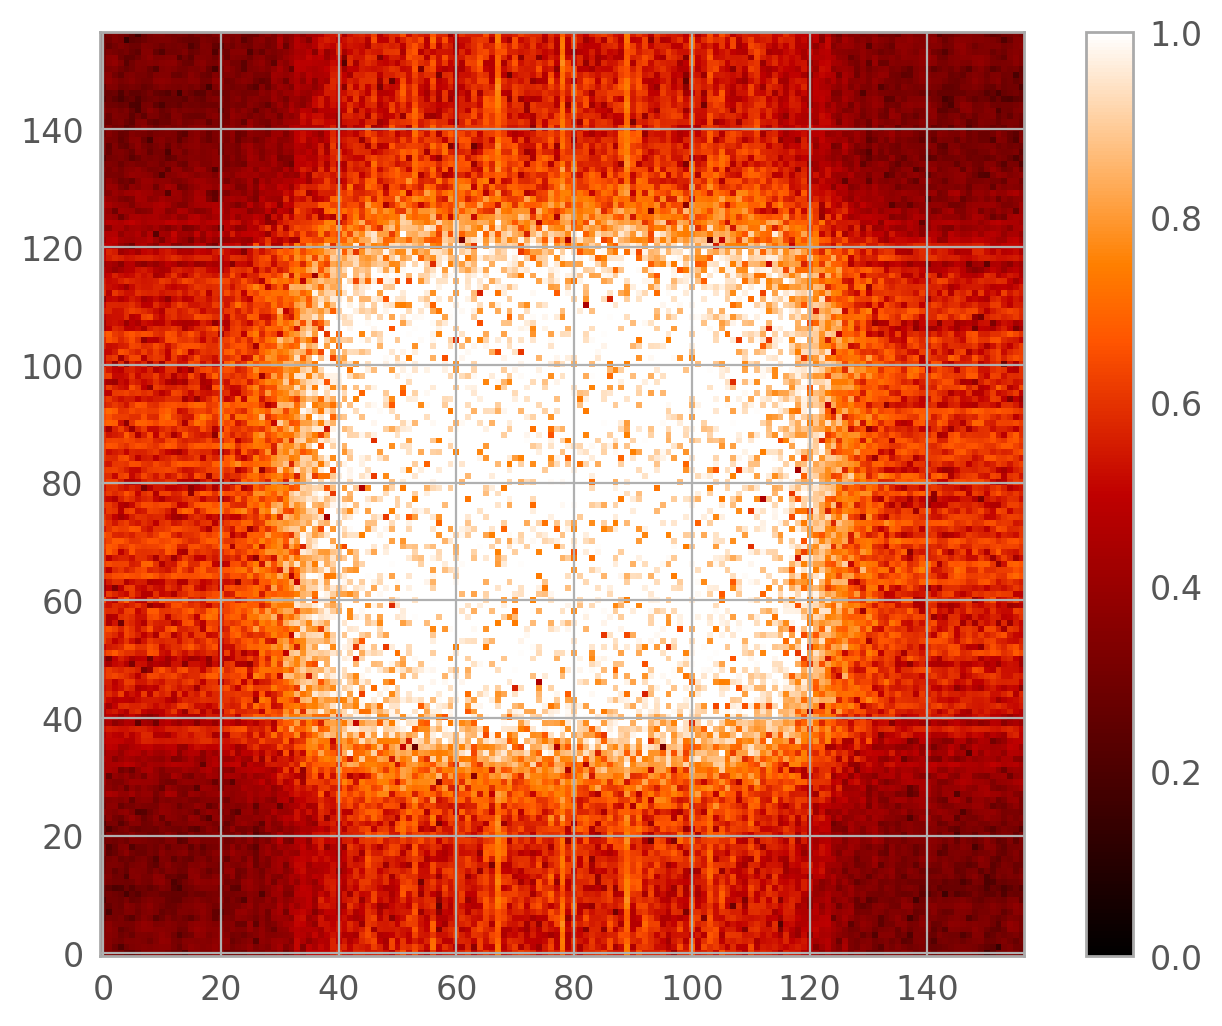

In [98]:
# pow = dutils.get_power_spectrum_from_realfft2d(wrapper.fft(proper_coadd_image))
pow = dutils.get_power_spectrum(fft.fft2(minimal_drizzled_image))
plt.imshow(pow**0.1, vmin=0, vmax=1)
plt.colorbar()

### Use JWST pipeline to do drizzle

In [99]:
# prepare files
dither_image_dir = 'dither_images/WebbPSF'
input_files = [os.path.join(dither_image_dir, filename) 
               for filename in os.listdir(dither_image_dir)]
input_models = ModelLibrary(input_files)

# define resampler
resampler = ResampleStep(
    pixel_scale=app/2, rotation=0, crpix=(79, 79), crval=(0, 0)
)

# generate drizzled iamge
result = resampler.process(input_models)

jwstpipe_drizzled_image = result.data[1:158, 1:158]/4

2024-11-29 21:12:06,921 - stpipe.ResampleStep - INFO - ResampleStep instance created.
2024-11-29 21:12:06,925 - stpipe - INFO - Driz parameter kernel: square
2024-11-29 21:12:06,926 - stpipe - INFO - Driz parameter pixfrac: 1.0
2024-11-29 21:12:06,927 - stpipe - INFO - Driz parameter fillval: NAN
2024-11-29 21:12:06,928 - stpipe - INFO - Driz parameter weight_type: ivm
2024-11-29 21:12:06,928 - stpipe - INFO - Output pixel scale: 0.0315 arcsec.
2024-11-29 21:12:07,019 - stpipe - INFO - Resampling science data
2024-11-29 21:12:07,034 - stpipe - INFO - Drizzling (79, 79) --> (217, 235)
2024-11-29 21:12:07,050 - stpipe - INFO - Drizzling (79, 79) --> (217, 235)
2024-11-29 21:12:07,065 - stpipe - INFO - Drizzling (79, 79) --> (217, 235)
2024-11-29 21:12:07,080 - stpipe - INFO - Drizzling (79, 79) --> (217, 235)
2024-11-29 21:12:07,095 - stpipe - INFO - Drizzling (79, 79) --> (217, 235)
2024-11-29 21:12:07,109 - stpipe - INFO - Drizzling (79, 79) --> (217, 235)
2024-11-29 21:12:07,125 - stp

show result

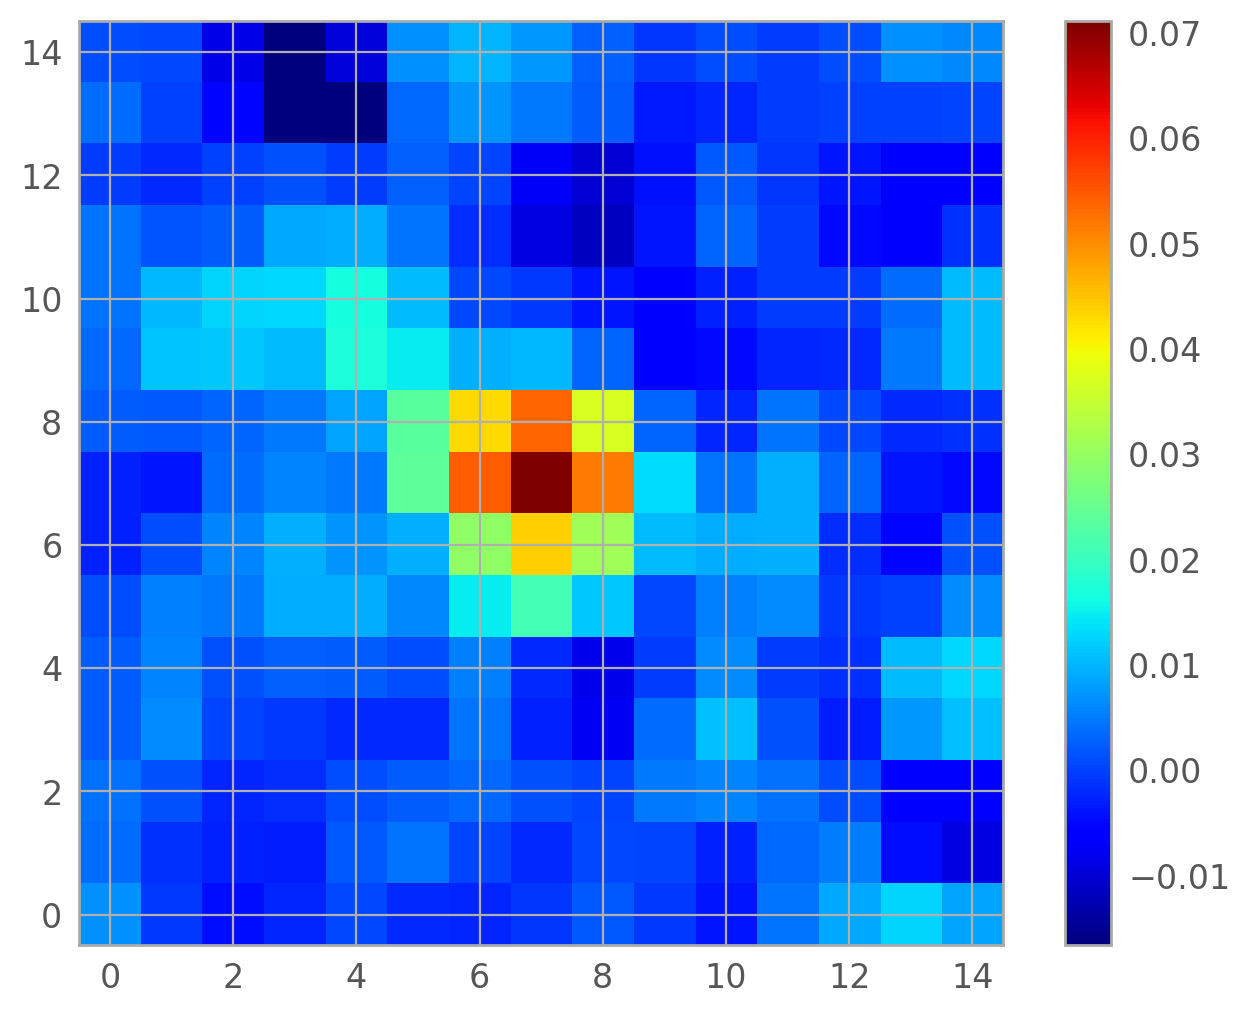

In [100]:
plt.imshow(dutils.extract_central_region(jwstpipe_drizzled_image), cmap='jet')
plt.colorbar()

test residual

0.028760074232255354

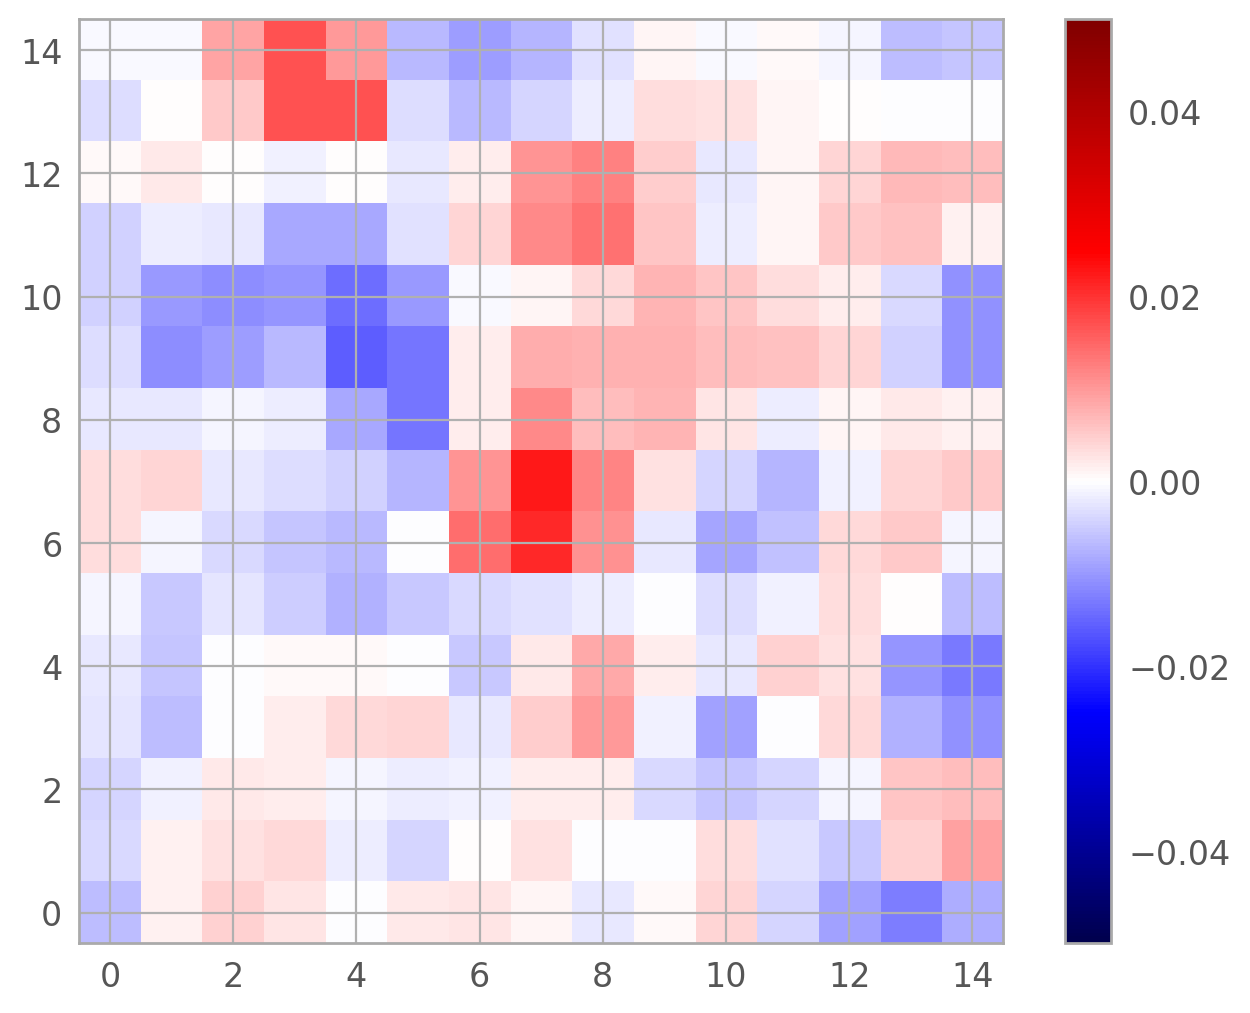

In [101]:
res = oversampled_data - jwstpipe_drizzled_image
plt.imshow(dutils.extract_central_region(res),
           cmap='seismic', vmin=-0.05, vmax=0.05)
plt.colorbar()

np.max(np.abs(res))

show power spectrum

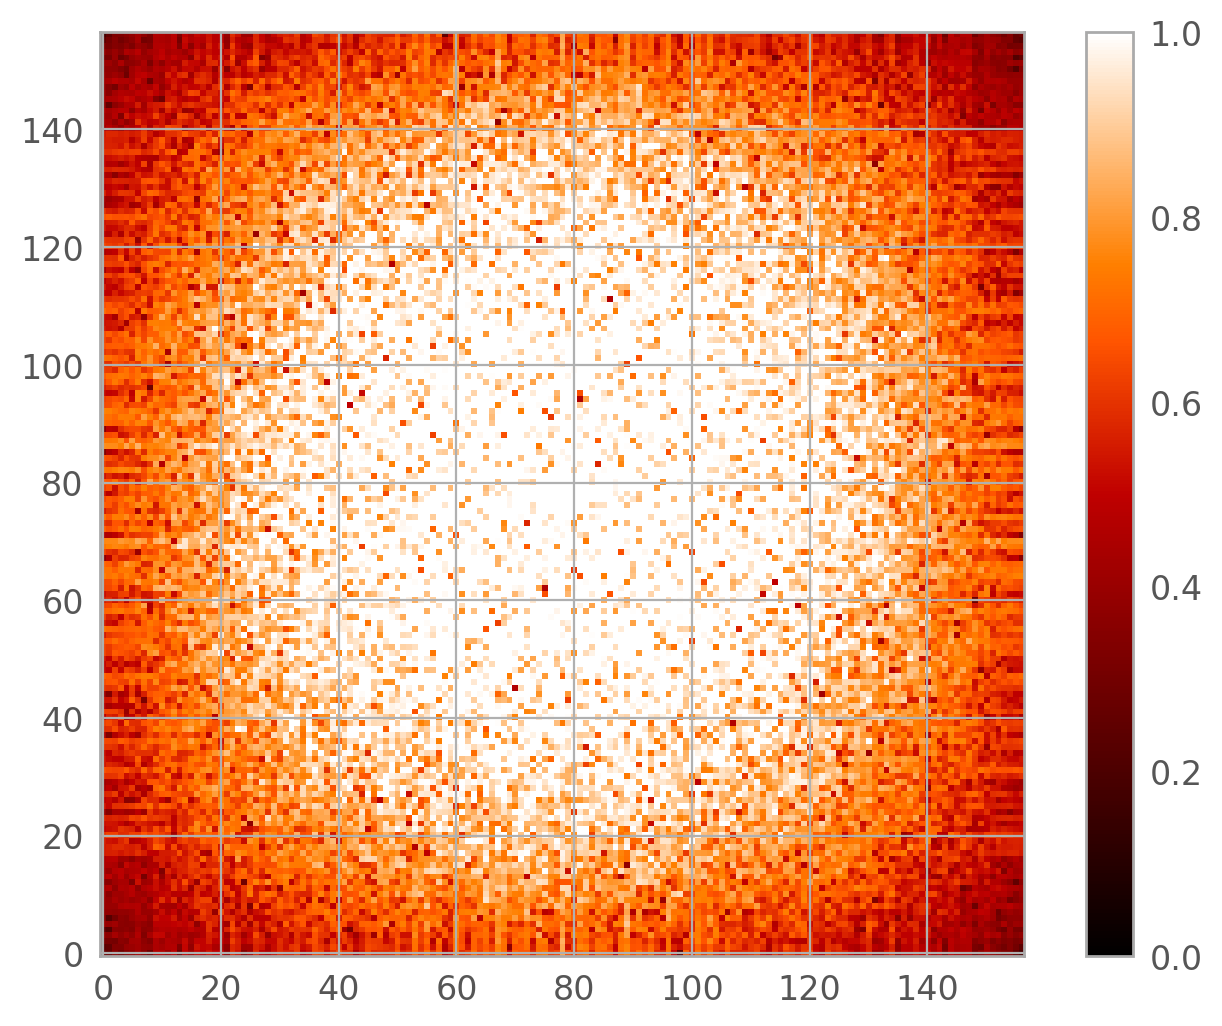

In [102]:
# pow = dutils.get_power_spectrum_from_realfft2d(wrapper.fft(proper_coadd_image))
pow = dutils.get_power_spectrum(fft.fft2(jwstpipe_drizzled_image))
plt.imshow(pow**0.1, vmin=0, vmax=1)
plt.colorbar()

### Do drizzle using reproject_interp based on WCS (used by Unfold_JWST)

In [103]:
# output_wcs gwcs construction
detector_frame = cf.Frame2D(
    name="detector", axes_names=("x", "y"), unit=(u.pix, u.pix), 
    axes_order=(0, 1)
)
sky_frame = cf.CelestialFrame(
    reference_frame=coord.ICRS(), name='icrs', unit=(u.deg, u.deg), 
    axes_names=('lon', 'lat'), axes_order=(0, 1)
)
pixel_center = models.Shift(offset=-78., name='crpix1') & \
                models.Shift(offset=-78., name='crpix2')
pc_rotation_matrix = models.AffineTransformation2D(
    matrix=[[1., 0.], [ 0., 1.]], translation=[0., 0.], 
    name='pc_rotation_matrix'
)
pixel_scale = models.Scale(factor=app/3600./2., name='cdelt1') & \
                models.Scale(factor=app/3600./2., name='cdelt2') # deg/pixel
tangent_projection = models.Pix2Sky_Gnomonic()
celestial_rotation = models.RotateNative2Celestial(
    lon=0., lat=0., lon_pole=180.
)
forward_transorm = pixel_center | pc_rotation_matrix | pixel_scale | \
                    tangent_projection | celestial_rotation
output_wcs = gwcs.wcs.WCS(
    forward_transform=forward_transorm,
    input_frame=detector_frame,
    output_frame=sky_frame
)

# prepare files
dither_image_dir = 'dither_images/WebbPSF'
input_files = [os.path.join(dither_image_dir, filename) 
               for filename in os.listdir(dither_image_dir)]

# do interpolation

interpolated_images = []
for i in range(len(input_files)):
    with ImageModel(input_files[i]) as model:
        array_new, footprint = reproject_interp(
            input_data=(model.data, model.meta.wcs), shape_out=(157, 157),
            output_projection=output_wcs, # order=1 (bilinear) used by default
        )
        interpolated_images.append(array_new)
        
reproject_drizzled_image = np.nanmean(interpolated_images, axis=0)/4

show result

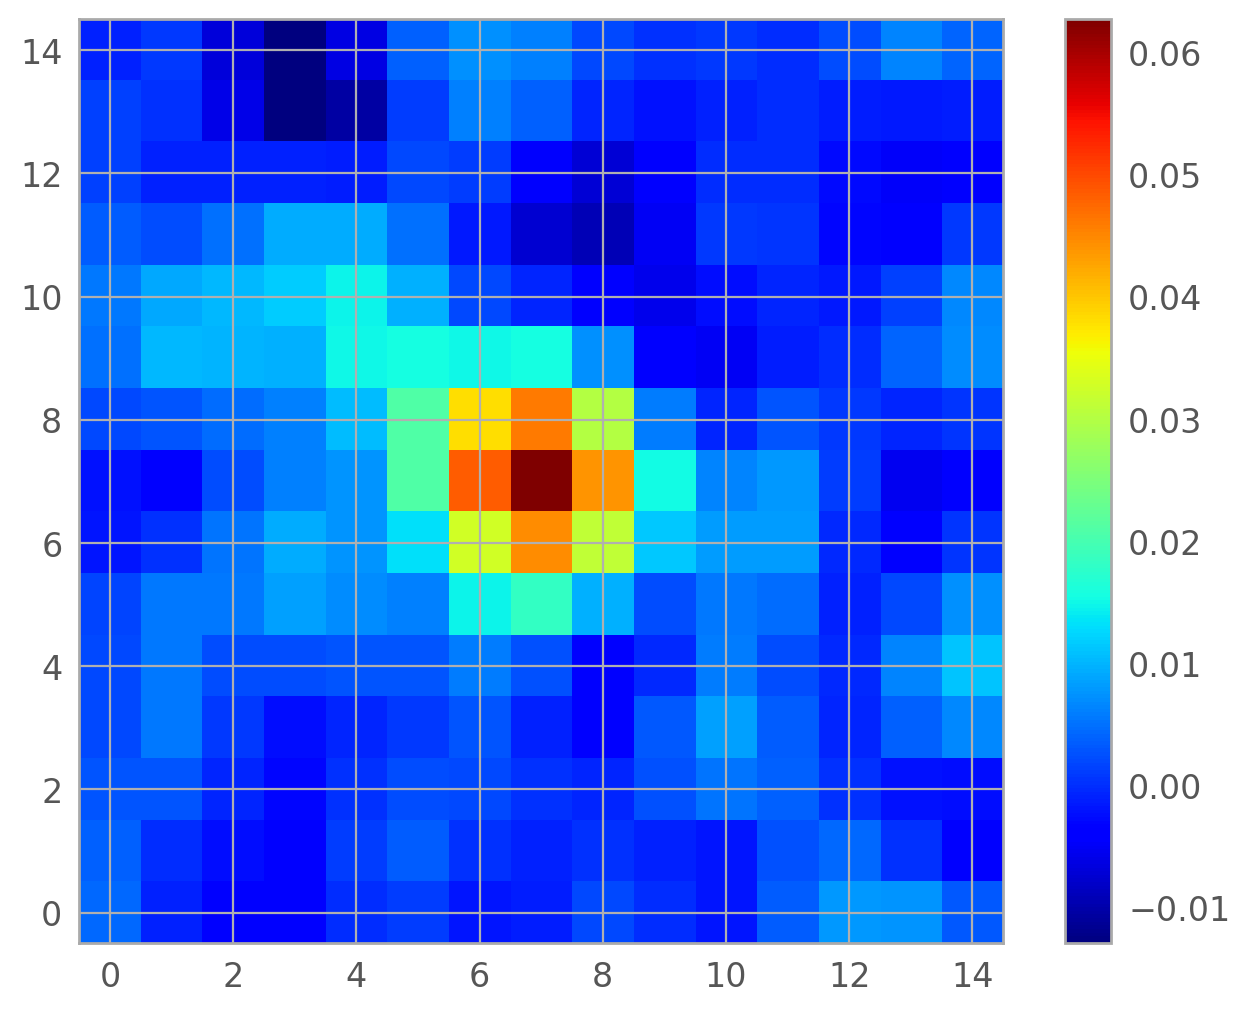

In [104]:
plt.imshow(dutils.extract_central_region(reproject_drizzled_image), cmap='jet')
plt.colorbar()

test residual

0.030947707090912727

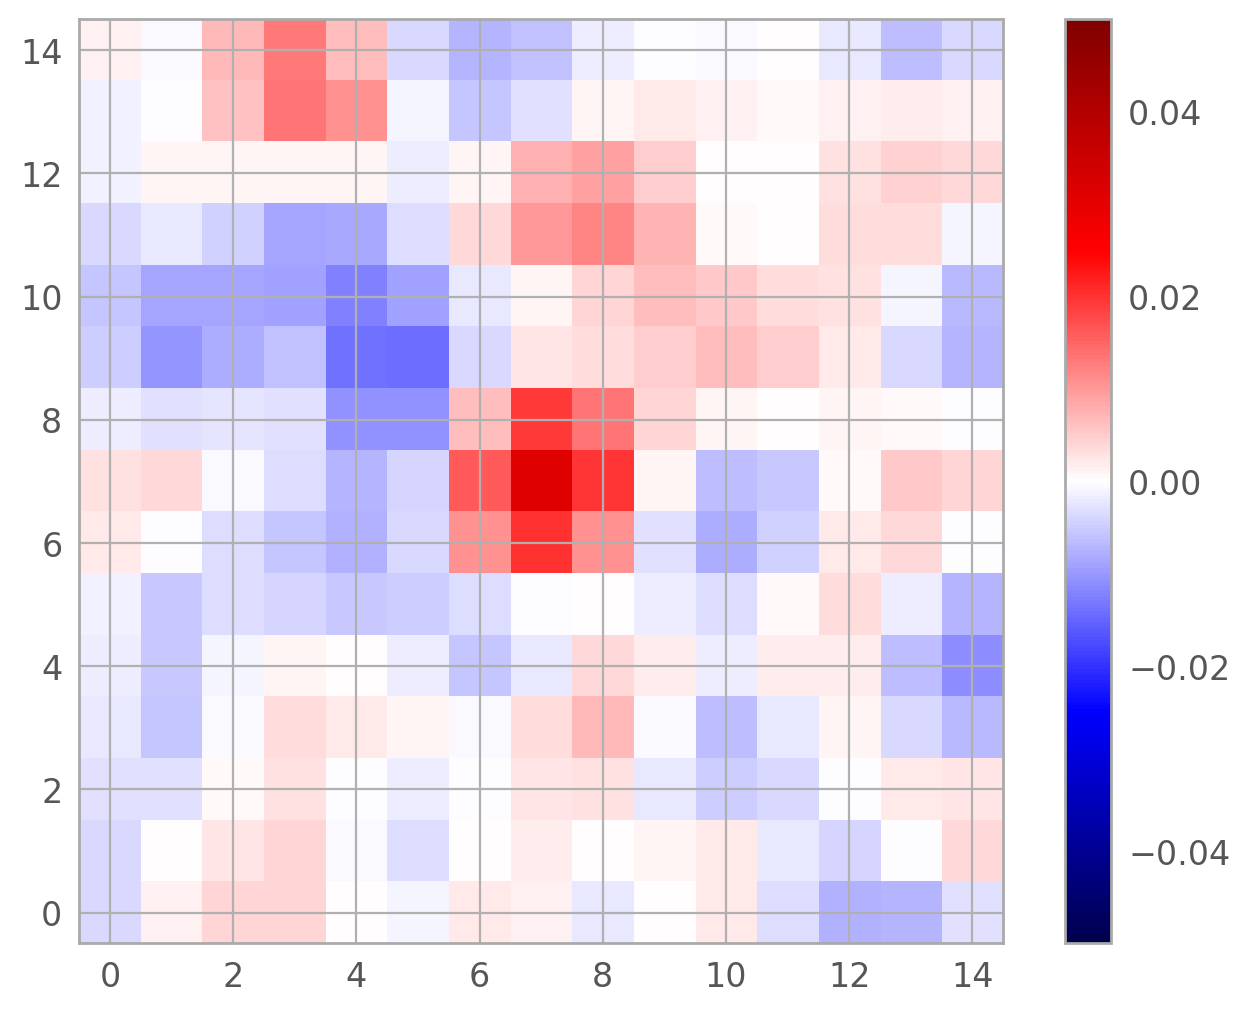

In [105]:
res = oversampled_data - reproject_drizzled_image
plt.imshow(dutils.extract_central_region(res),
           cmap='seismic', vmin=-0.05, vmax=0.05)
plt.colorbar()

np.max(np.abs(res))

show power spectrum

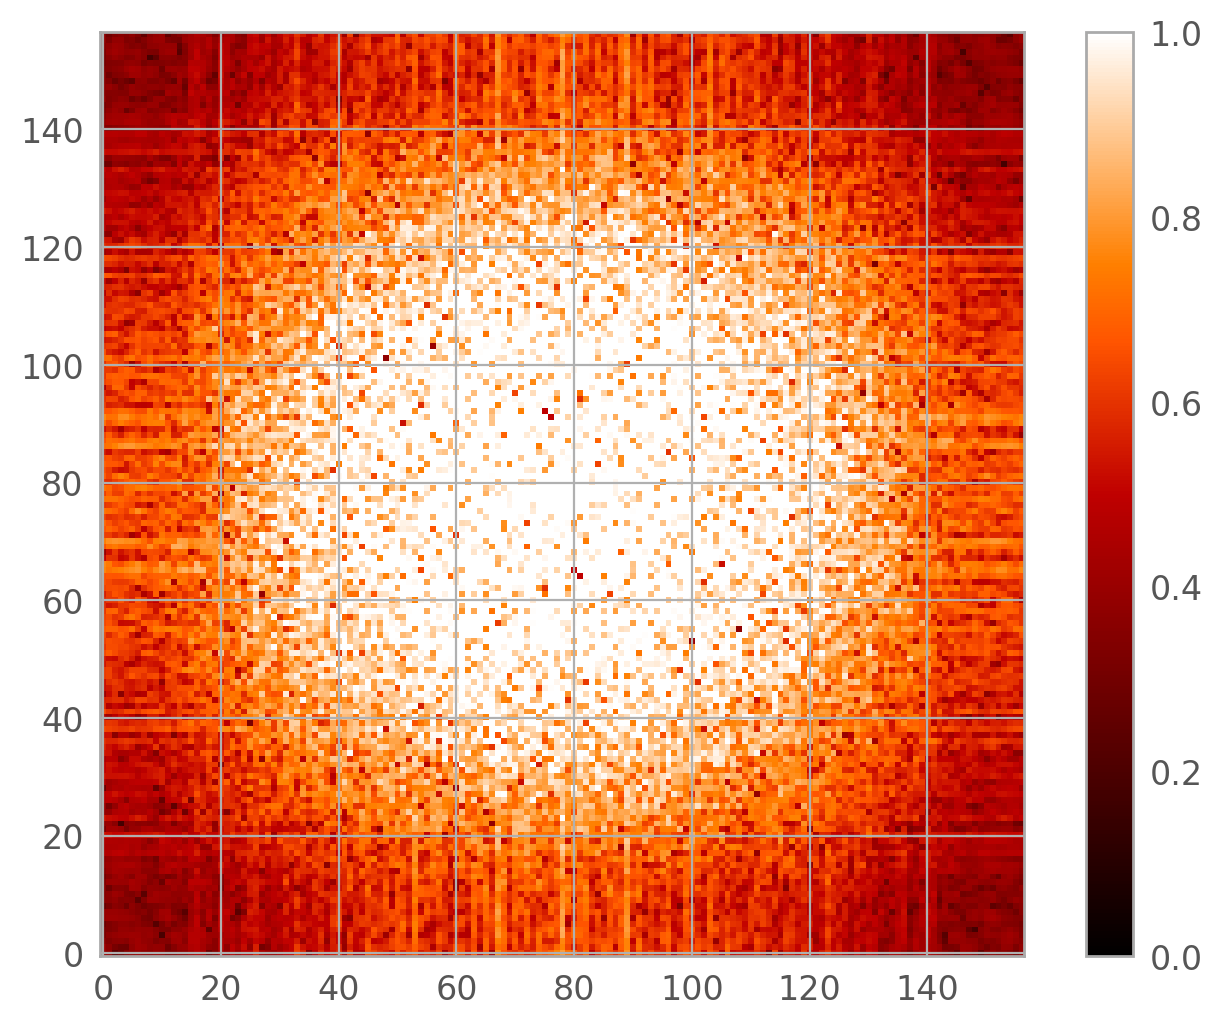

In [106]:
# pow = dutils.get_power_spectrum_from_realfft2d(wrapper.fft(proper_coadd_image))
pow = dutils.get_power_spectrum(fft.fft2(reproject_drizzled_image))
plt.imshow(pow**0.1, vmin=0, vmax=1)
plt.colorbar()

### Do dirzzle using astrodrizzle (used by HST pipeline? Not cecessary?)

In [107]:
dither_image_dir = 'dither_images/WebbPSF'
input_files = [os.path.join(dither_image_dir, filename) 
               for filename in os.listdir(dither_image_dir)]

In [108]:
# from drizzlepac import astrodrizzle

# # Define parameters for AstroDrizzle
# input_files = input_files  # Use wildcard for all _flt.fits files in the directory
# output_name = 'final'      # Base name for the output files
# wcs_key = 'A'              # Use WCS key 'A', aligned by TweakReg
# driz_sep_bits = '64,32'    # Ignore pixels flagged with DQ values 64 and 32
# final_pixel_scale = 0.05   # Final output pixel scale in arcseconds/pixel
# final_rotation = 0.0       # Align the image such that North is up

# for i in range(len(input_files)):
#     with fits.open(input_files[i], mode='update') as hdul:
#         # Access the primary header
#         hdr = hdul[0].header

#         # Add or update the 'INSTRUME' keyword
#         hdr['INSTRUME'] = 'NIRCam'

#         # Save the changes by closing the file
#         hdul.flush()


# # Run AstroDrizzle
# astrodrizzle.AstroDrizzle(
#     input=input_files,
#     output=output_name,
#     wcskey=wcs_key,
#     driz_sep_bits=driz_sep_bits,
#     final_scale=final_pixel_scale,
#     final_rot=final_rotation,
#     final_wcs=True  # Use WCS-aligned output
# )

# print('AstroDrizzle processing complete. Check the output files in the current directory.')


## Show residuals in one plot

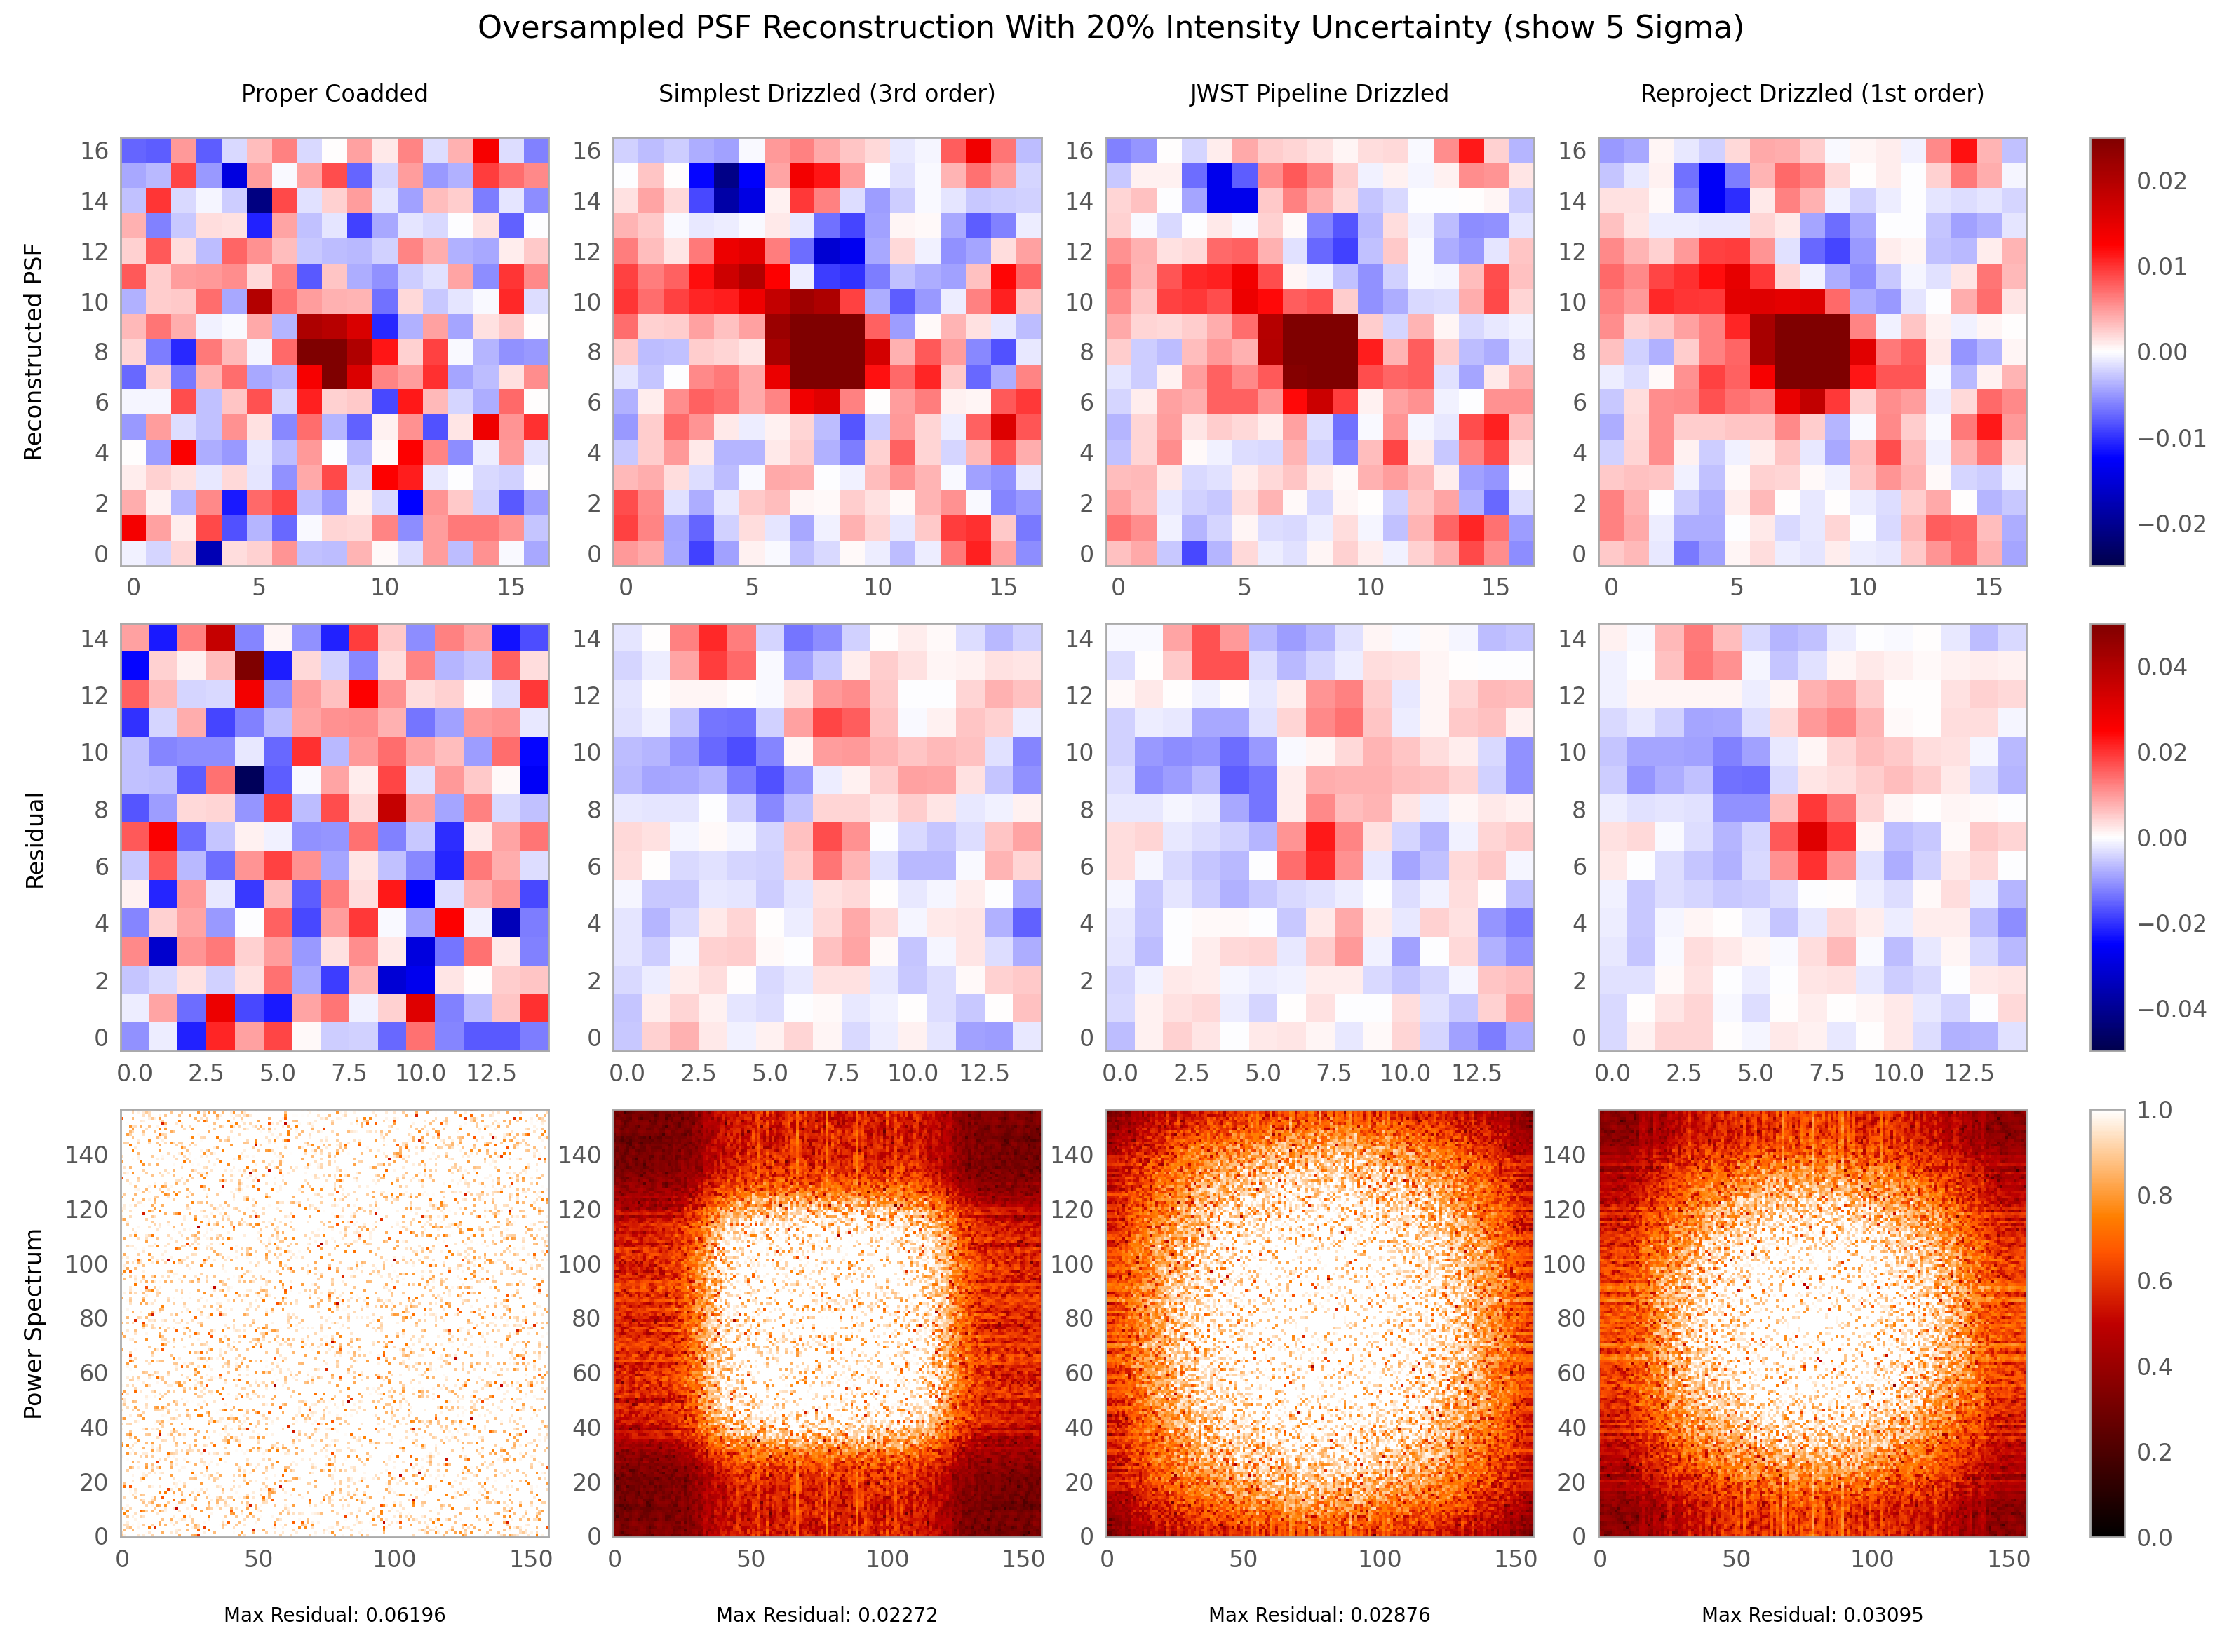

In [116]:
image_list = [
    proper_coadded_image,
    minimal_drizzled_image,
    jwstpipe_drizzled_image,
    reproject_drizzled_image
]

# Row labels and column titles
row_labels = ['Reconstructed PSF', 'Residual', 'Power Spectrum']
column_titles = ['Proper Coadded', 'Simplest Drizzled (3rd order)', 'JWST Pipeline Drizzled', 'Reproject Drizzled (1st order)']

# Create the figure
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(4, 6, width_ratios=[0.1, 1, 1, 1, 1, 0.08], height_ratios=[1, 1, 1, 0.1], figure=fig)

# Add super title
# fig.suptitle('Oversampled PSF Reconstruction Without Noise', fontsize=16, y=0.98)
# fig.suptitle('Oversampled PSF Reconstruction With 20% Position Uncertainty', fontsize=16, y=0.98)
# fig.suptitle('Oversampled PSF Reconstruction With 20% Intensity Uncertainty', fontsize=16, y=0.98)
fig.suptitle('Oversampled PSF Reconstruction With 20% Intensity Uncertainty (show 5 Sigma)', fontsize=16, y=0.98)

# Add row labels
for row, label in enumerate(row_labels):
    ax_label = fig.add_subplot(gs[row, 0])
    ax_label.text(0.5, 0.5, label, rotation=90, ha='center', va='center', fontsize=12)
    ax_label.axis('off')

# Initialize a list to store max residual values
max_residuals = []

# Iterate over images to generate plots
for col, image in enumerate(image_list):
    # Add column titles
    ax_title = fig.add_subplot(gs[0, col + 1])
    ax_title.text(
        0.5, 1.1, column_titles[col],  # Adjust the y-coordinate here
        ha='center', va='center', fontsize=12, transform=ax_title.transAxes
    )
    ax_title.axis('off')

    # Row 1: Result
    vmax = sigma_clipped_stats(image)[2]*5
    ax_result = fig.add_subplot(gs[0, col + 1])
    im_result = ax_result.imshow(
        dutils.extract_central_region(image, radius=8), cmap='seismic', 
        vmin=-vmax, vmax=vmax # vmin=np.min(image_list), vmax=np.max(image_list)
    )
    ax_result.grid(False)

    # Row 2: Residual
    ax_residual = fig.add_subplot(gs[1, col + 1])
    res = oversampled_data - image
    im_residual = ax_residual.imshow(
        dutils.extract_central_region(res), cmap='seismic', vmin=-0.05, vmax=0.05
    )
    max_residual = np.max(np.abs(res))
    max_residuals.append(max_residual)
    ax_residual.grid(False)

    # Row 3: Power Spectrum
    ax_power = fig.add_subplot(gs[2, col + 1])
    pow_spectrum = dutils.get_power_spectrum(np.fft.fft2(image))
    im_power = ax_power.imshow(pow_spectrum**0.1, vmin=0, vmax=1)
    ax_power.grid(False)

# Add max residual values below the second row
for col, max_residual in enumerate(max_residuals):
    ax_bottom_text = fig.add_subplot(gs[3, col + 1])
    ax_bottom_text.text(
        0.5, 0.5, f'Max Residual: {max_residual:6.5f}',
        ha='center', va='center', fontsize=10
    )
    ax_bottom_text.axis('off')

# Add colorbars for each row
for row, im in enumerate([im_result, im_residual, im_power]):
    cax = fig.add_subplot(gs[row, 5])
    fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for super title
plt.show()


In [110]:
# TODO: central pixel definition